<h1 style="text-align: center;">Time Series Forecasting of Day Ahead Energy Prices </h1>
<p style="text-align: center;"> A. Eshraghi </p>

## Summary

---

Modeling time series data is notoriously difficult; forecasting market trends even moreso. This notebook details preliminary efforts to model day ahead energy prices of just one node in the US energy markets. The data, sourced from S. Ponia's proprietary database of historical energy pricing, was fit to several time series models within the Python Statsmodels framework and evaluated for best fit. Ultimately a SARIMA(4,0,4)x(1,1,1,24) model was selected, achieving an R2 score of .940 within some constraints.

With more time, better fits with fewer conditions can be achieved. The road ahead includes the integration of exogenous variables to aid model accuracy when conditions are atypical, implementation in R to allow for the handling of multiple seasonality, and the introduction of ARCH and GARCH models to better handle heterskedacticity. The largest hurdle to overcome is the integration of this model with thousands of others like it, possibly as inputs to an LSTM recurrent neural network. Since proximate nodes affect one another, it is impossible to have a robust predictive model without taking the conditions of every node into consideration at once. Furthermore, optimal hyperparameteres may and likely will vary across different nodes. It is necessary to build an automated modeling process to determine the optimal model across thousands of nodes before such a collective model could be used.

## Analysis

---

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA, ARIMA
from fbprophet import Prophet
import statsmodels.api as sm
import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Increase dimensions of inline matplotlib visualizations

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 17
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [3]:
# Load ALTE data from CSV

df = pd.read_csv('./datasets/ALTE.csv', index_col='Unnamed: 0')
df.index = pd.to_datetime(df.index)

### Time series analysis framework

1) Visualize the data

2) Stationarize the data

3) Assess optimal parameters

4) Build the model

5) Make predictions

### 1) Data visualization

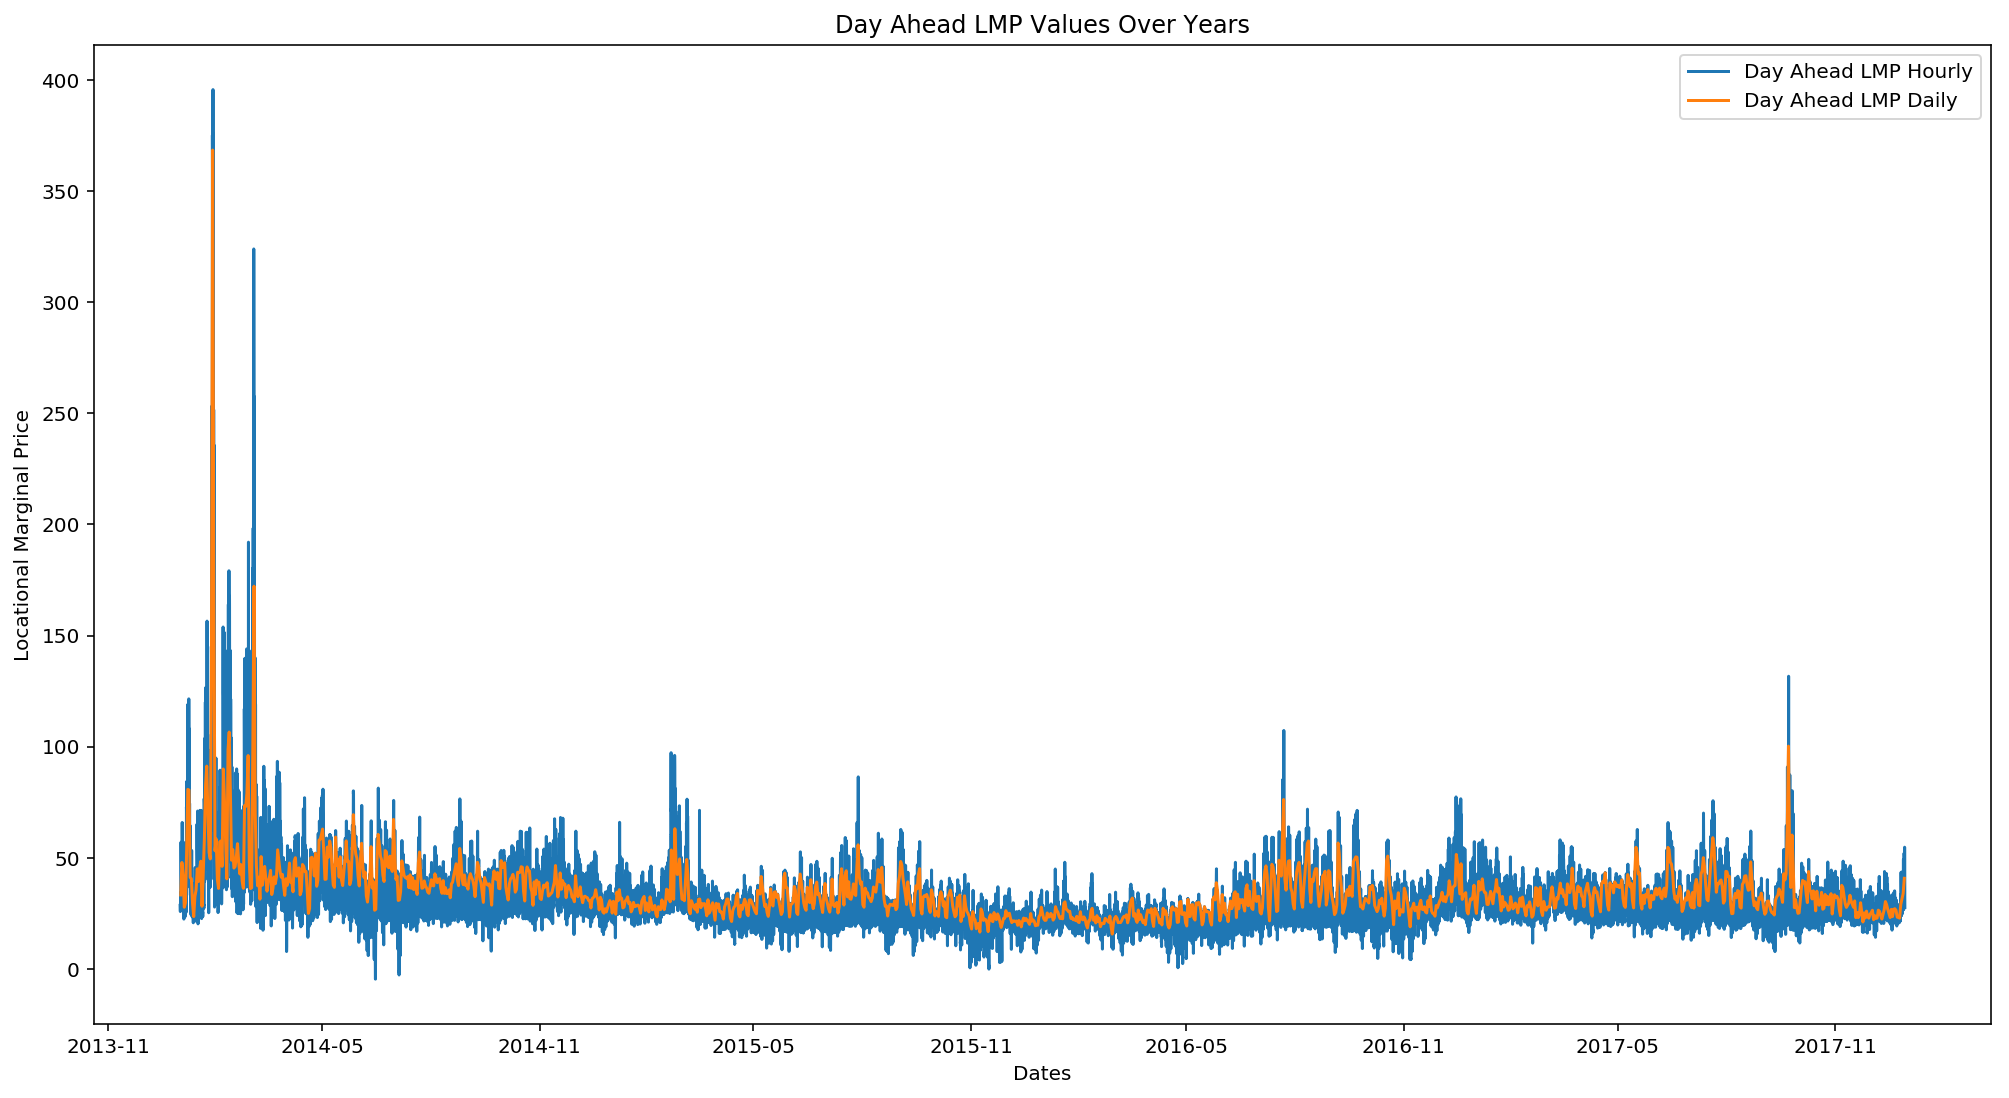

In [37]:
# It is immediately clear that there is not a significant non-seasonal trend
# at work in the data. For that matter, even seasonal trends aren't apparent
# at this scale. While there are a few points of notable variance spread about,
# the cause is not clear.
plt.plot(df['DA_LMP'], label='Day Ahead LMP Hourly')
plt.plot(df['DA_LMP'][12::24], label='Day Ahead LMP Daily')
plt.xlabel('Dates')
plt.ylabel('Locational Marginal Price')
plt.title('Day Ahead LMP Values Over Years')
plt.legend();

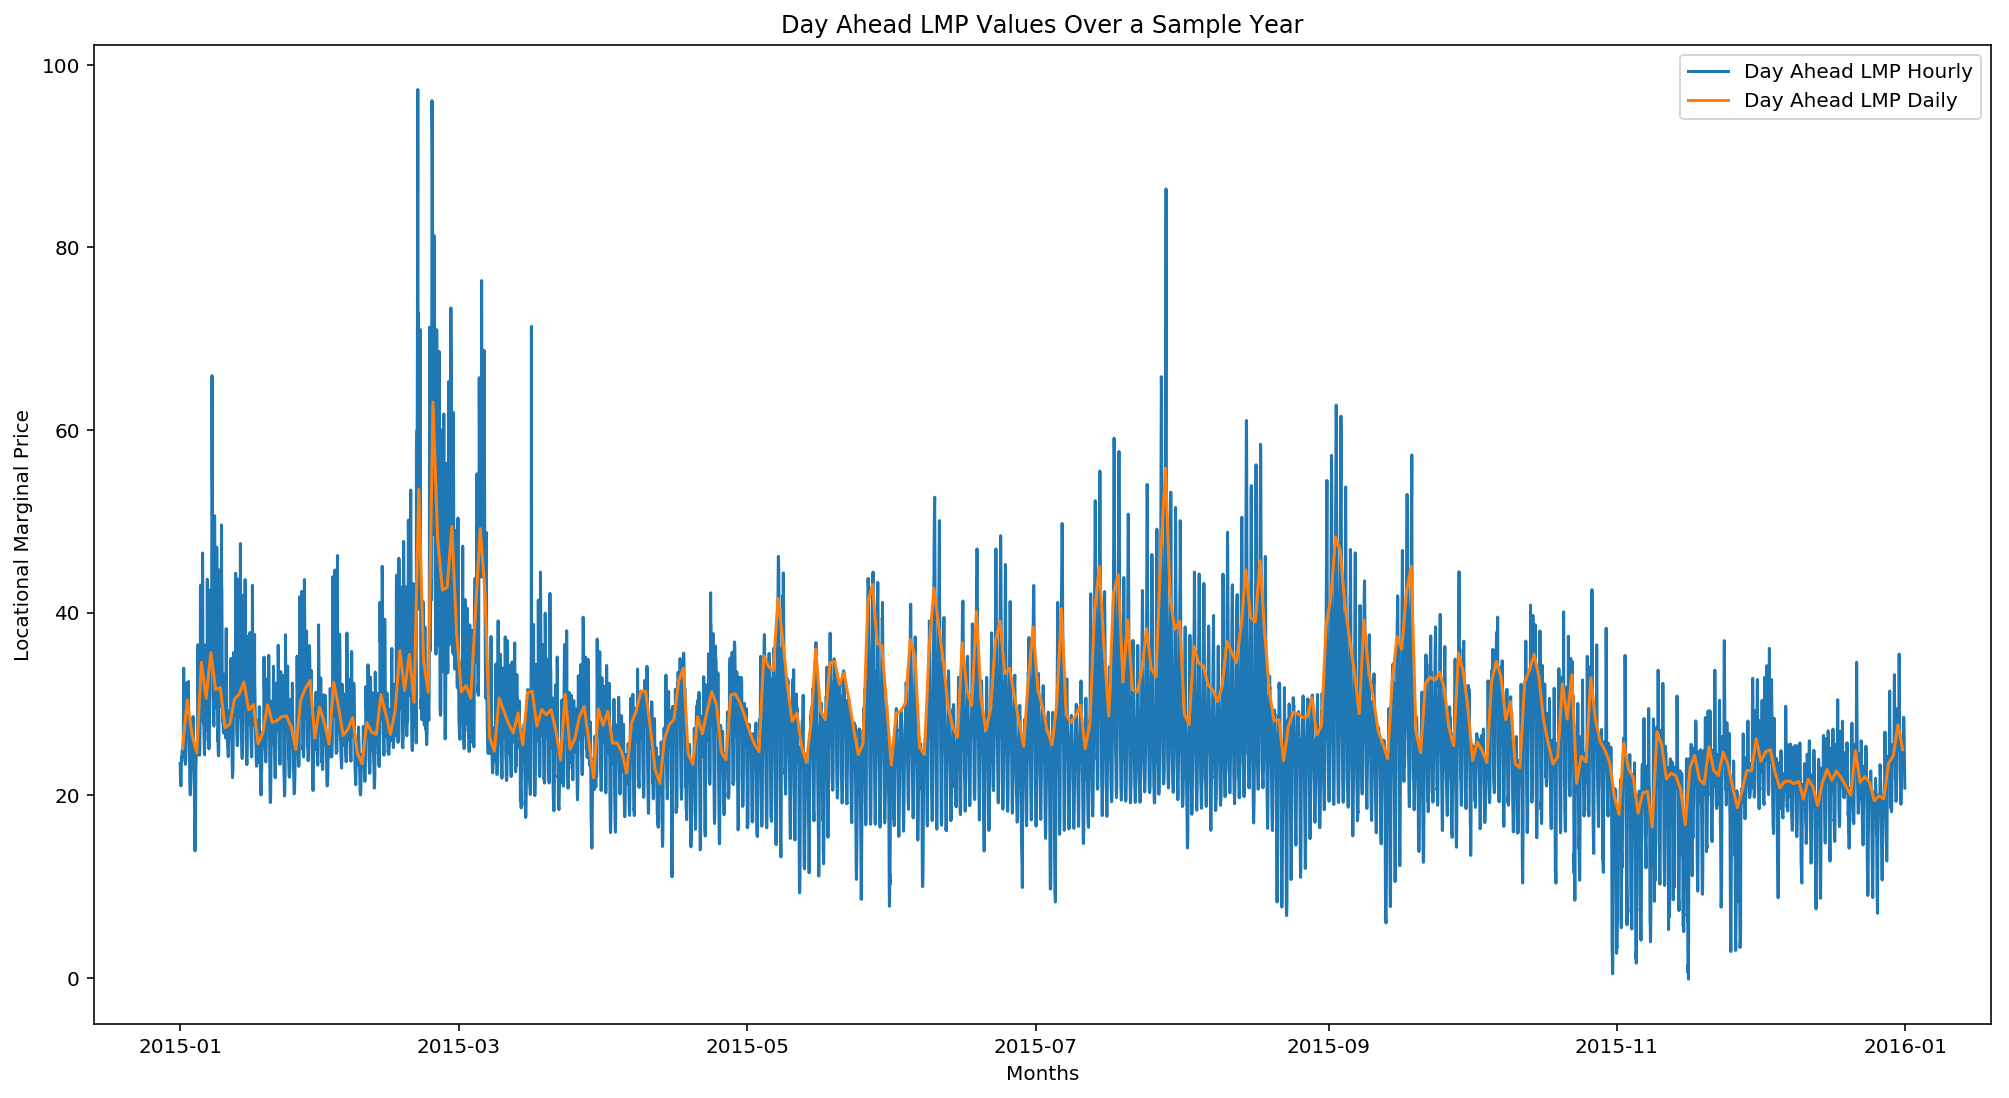

In [51]:
# We can now start to see a weekly behavior in the daily (orange) line.
plt.plot(df['DA_LMP']['2015'], label='Day Ahead LMP Hourly')
plt.plot(df['DA_LMP']['2015'][12::24], label='Day Ahead LMP Daily')
plt.xlabel('Months')
plt.ylabel('Locational Marginal Price')
plt.title('Day Ahead LMP Values Over a Sample Year')
plt.legend();

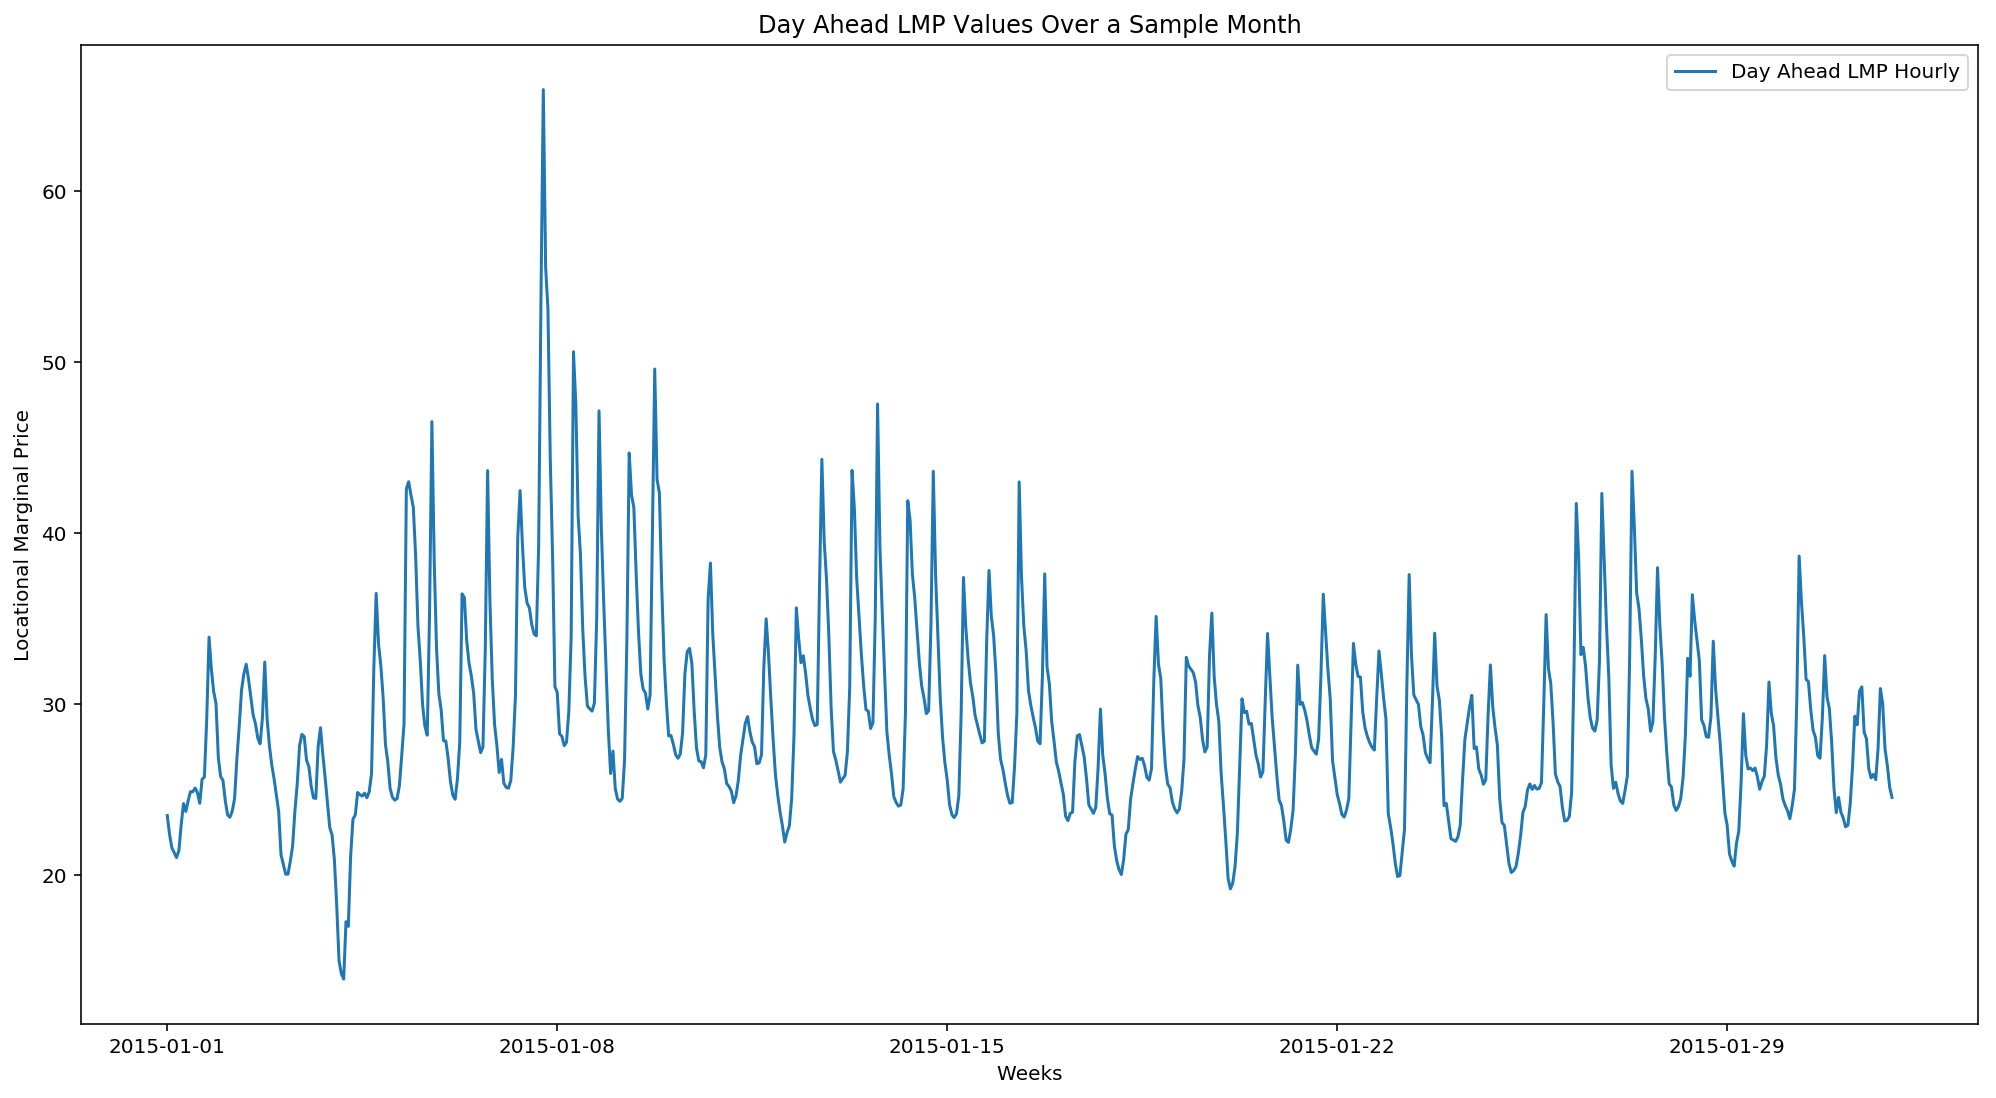

In [6]:
# A new pattern, genearlly consisting of one minor hump followed by a major
# hump and recurring every day, is shown by the hourly (blue) line. There also would seem to be four
# distinct sections that have higher hourly variance seperated by a day or two
# of slightly lower energy costs. Given the time span being examined, it is
# reasonable to infer that it very well could be the weekly trend seen in orange
# just above.
plt.plot(df['DA_LMP']['2015-01'], label='Day Ahead LMP Hourly')
plt.xlabel('Weeks')
plt.ylabel('Locational Marginal Price')
plt.title('Day Ahead LMP Values Over a Sample Month')
plt.legend();

#### Seasonal Decompositions

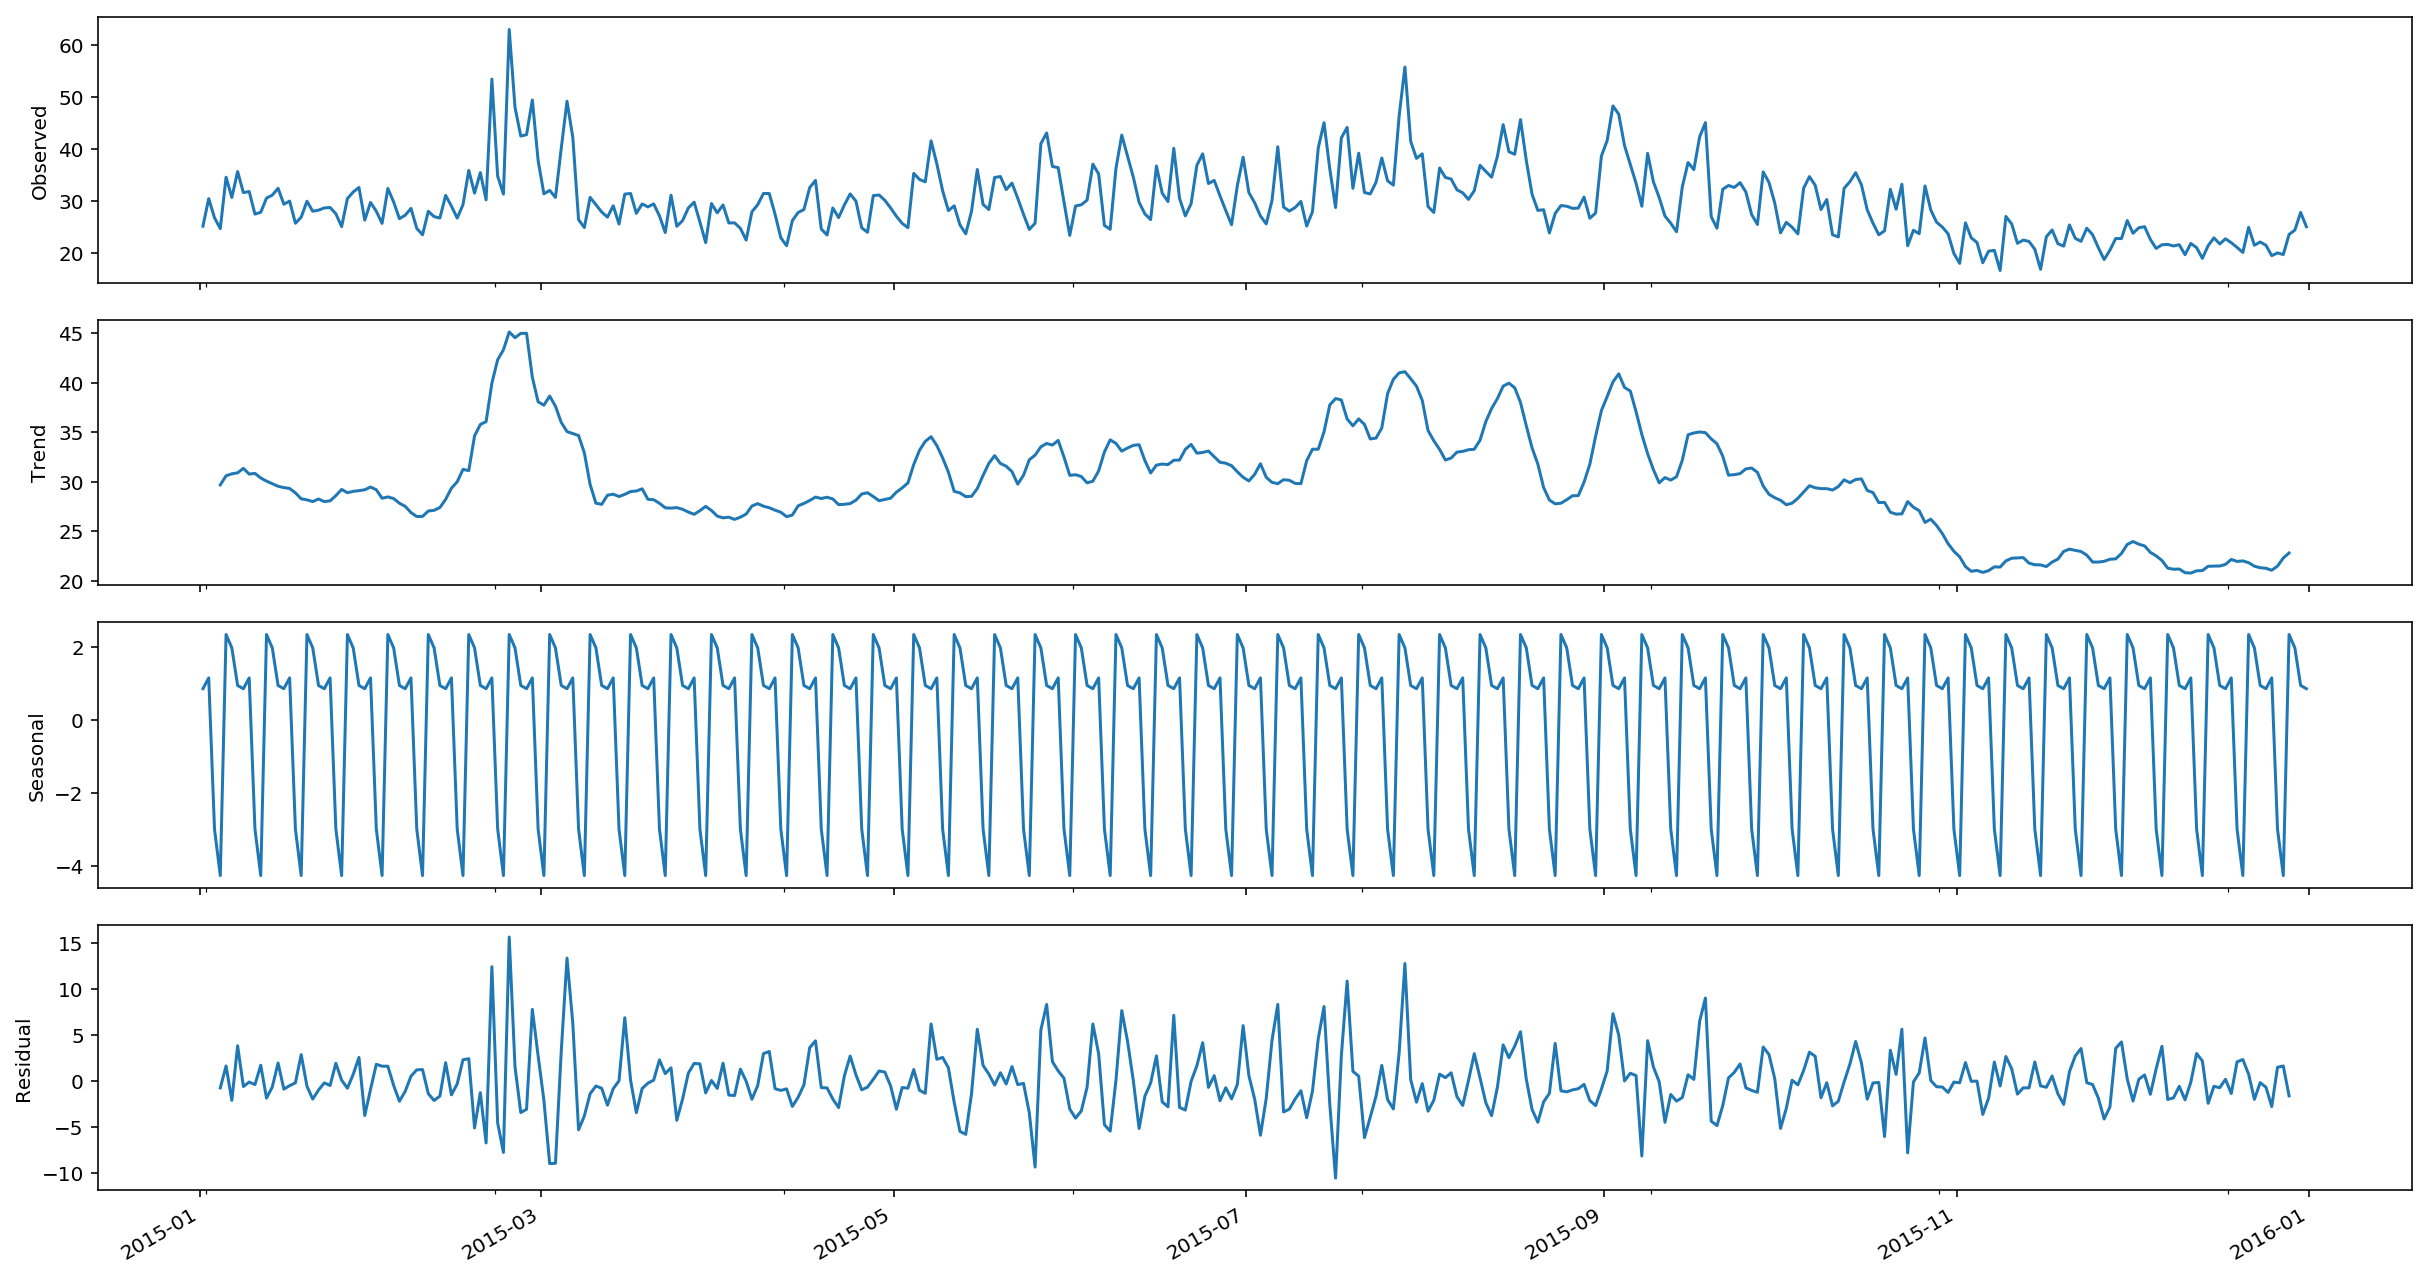

In [44]:
# Sticking to daily values, the seasonal component of the decomposition
# beautifully illustrates the weekly pattern.
seasonal_decompose(df['2015']['DA_LMP'][12::24]).plot();

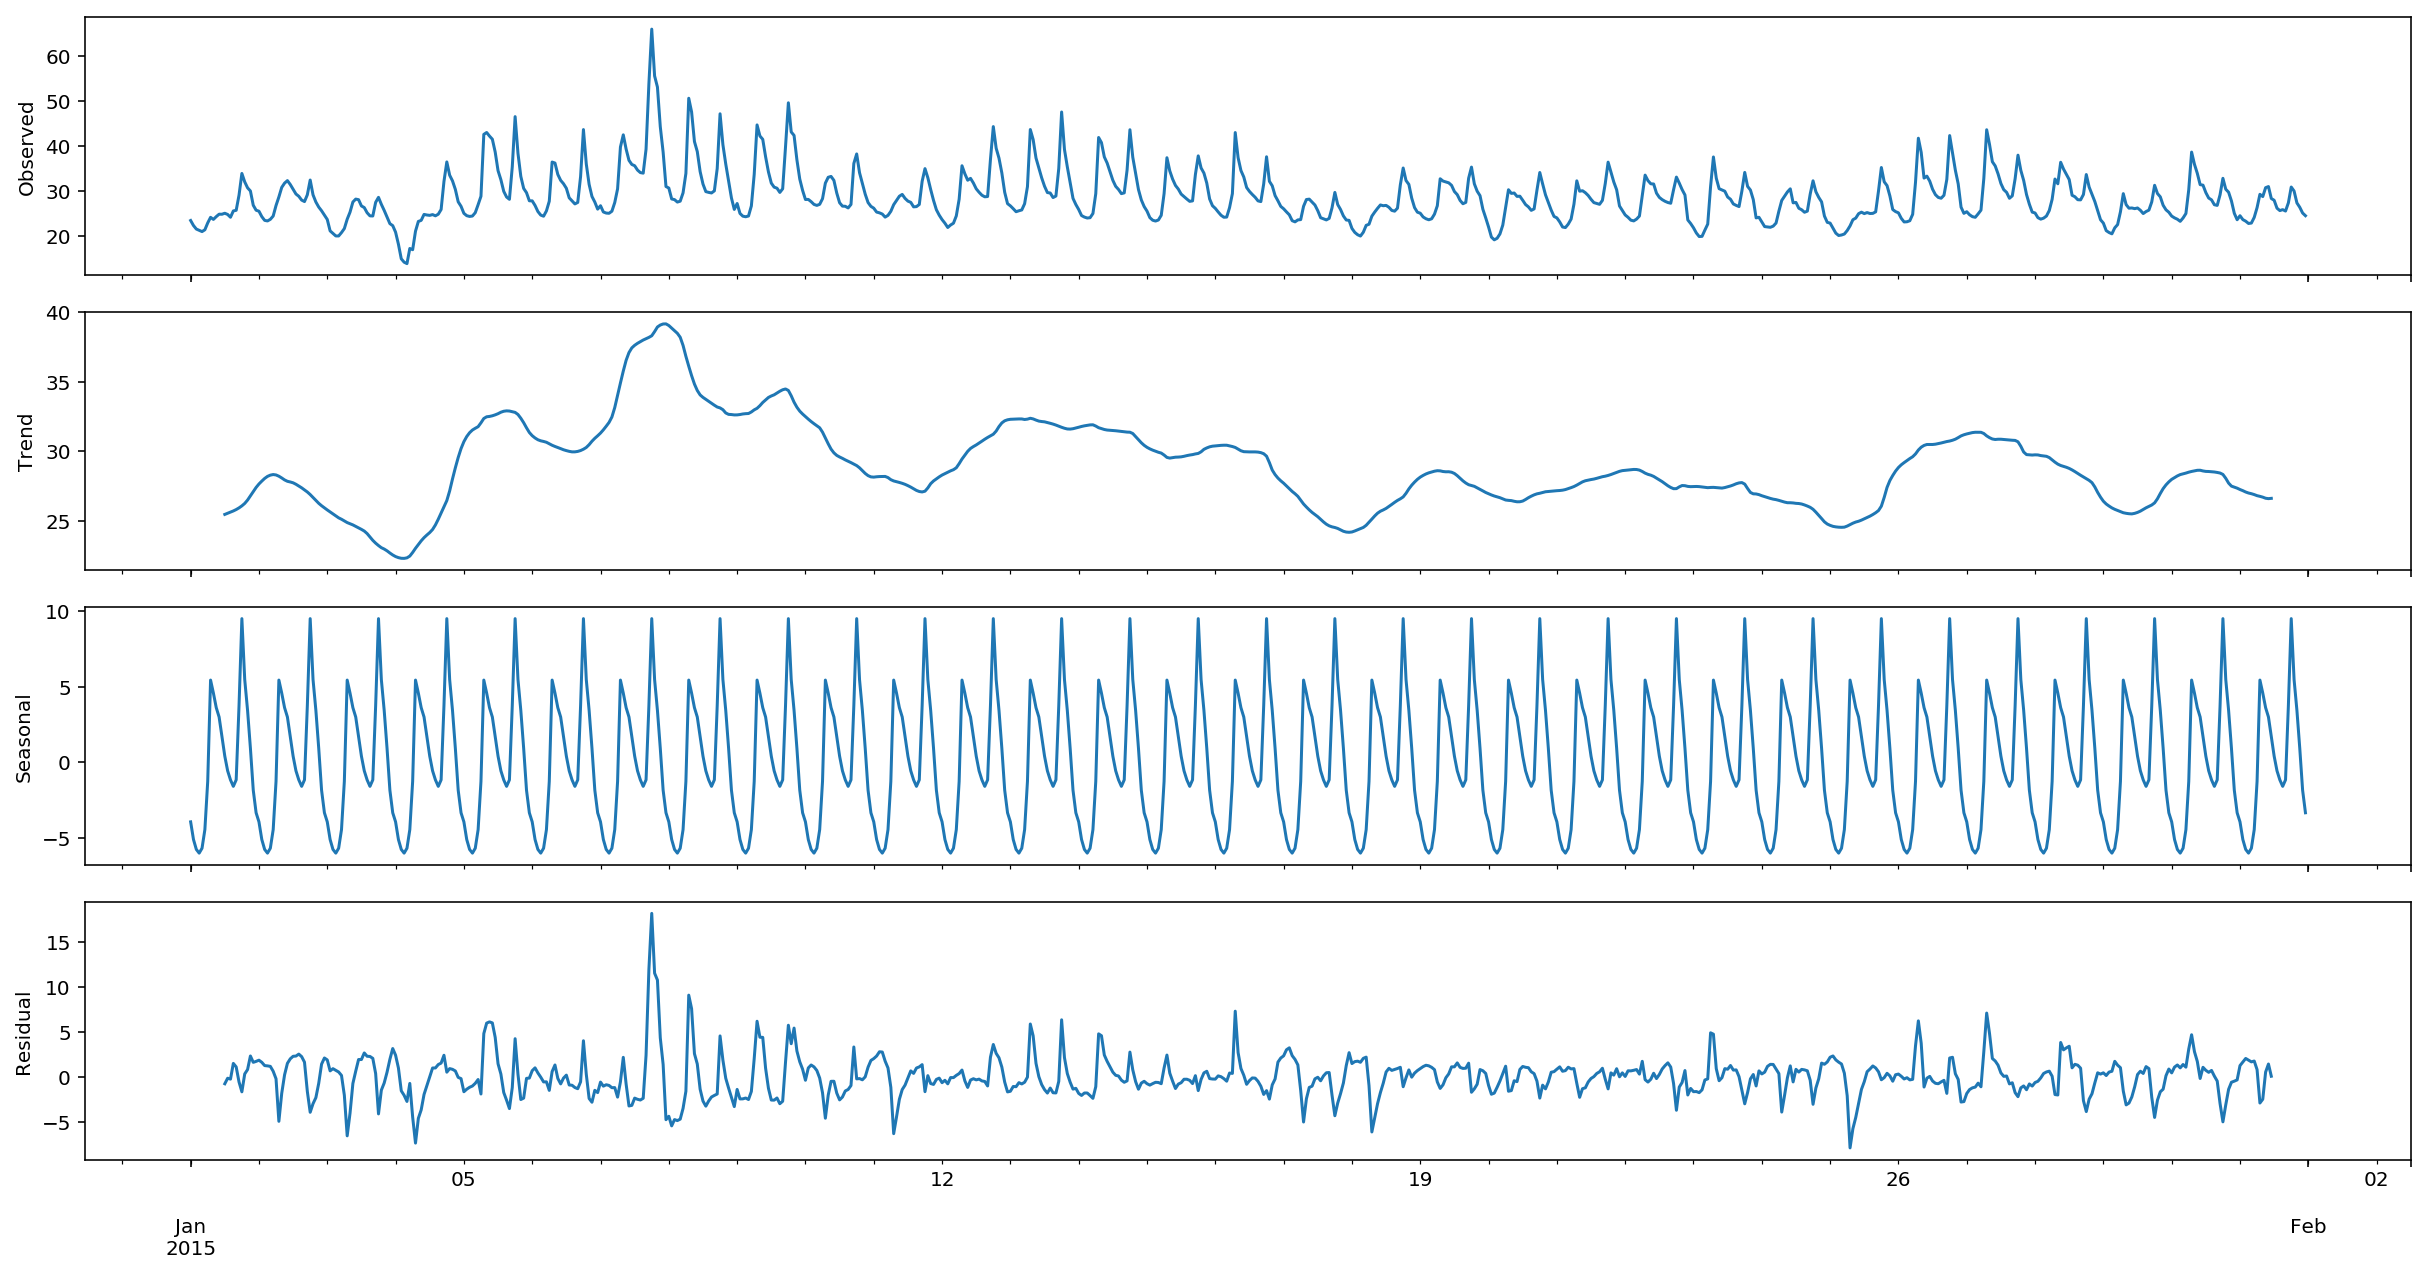

In [95]:
# Decomposing a month verifies the earlier speculation about the shape of the
# daily seasonality.
seasonal_decompose(df['2015-01']['DA_LMP']).plot();

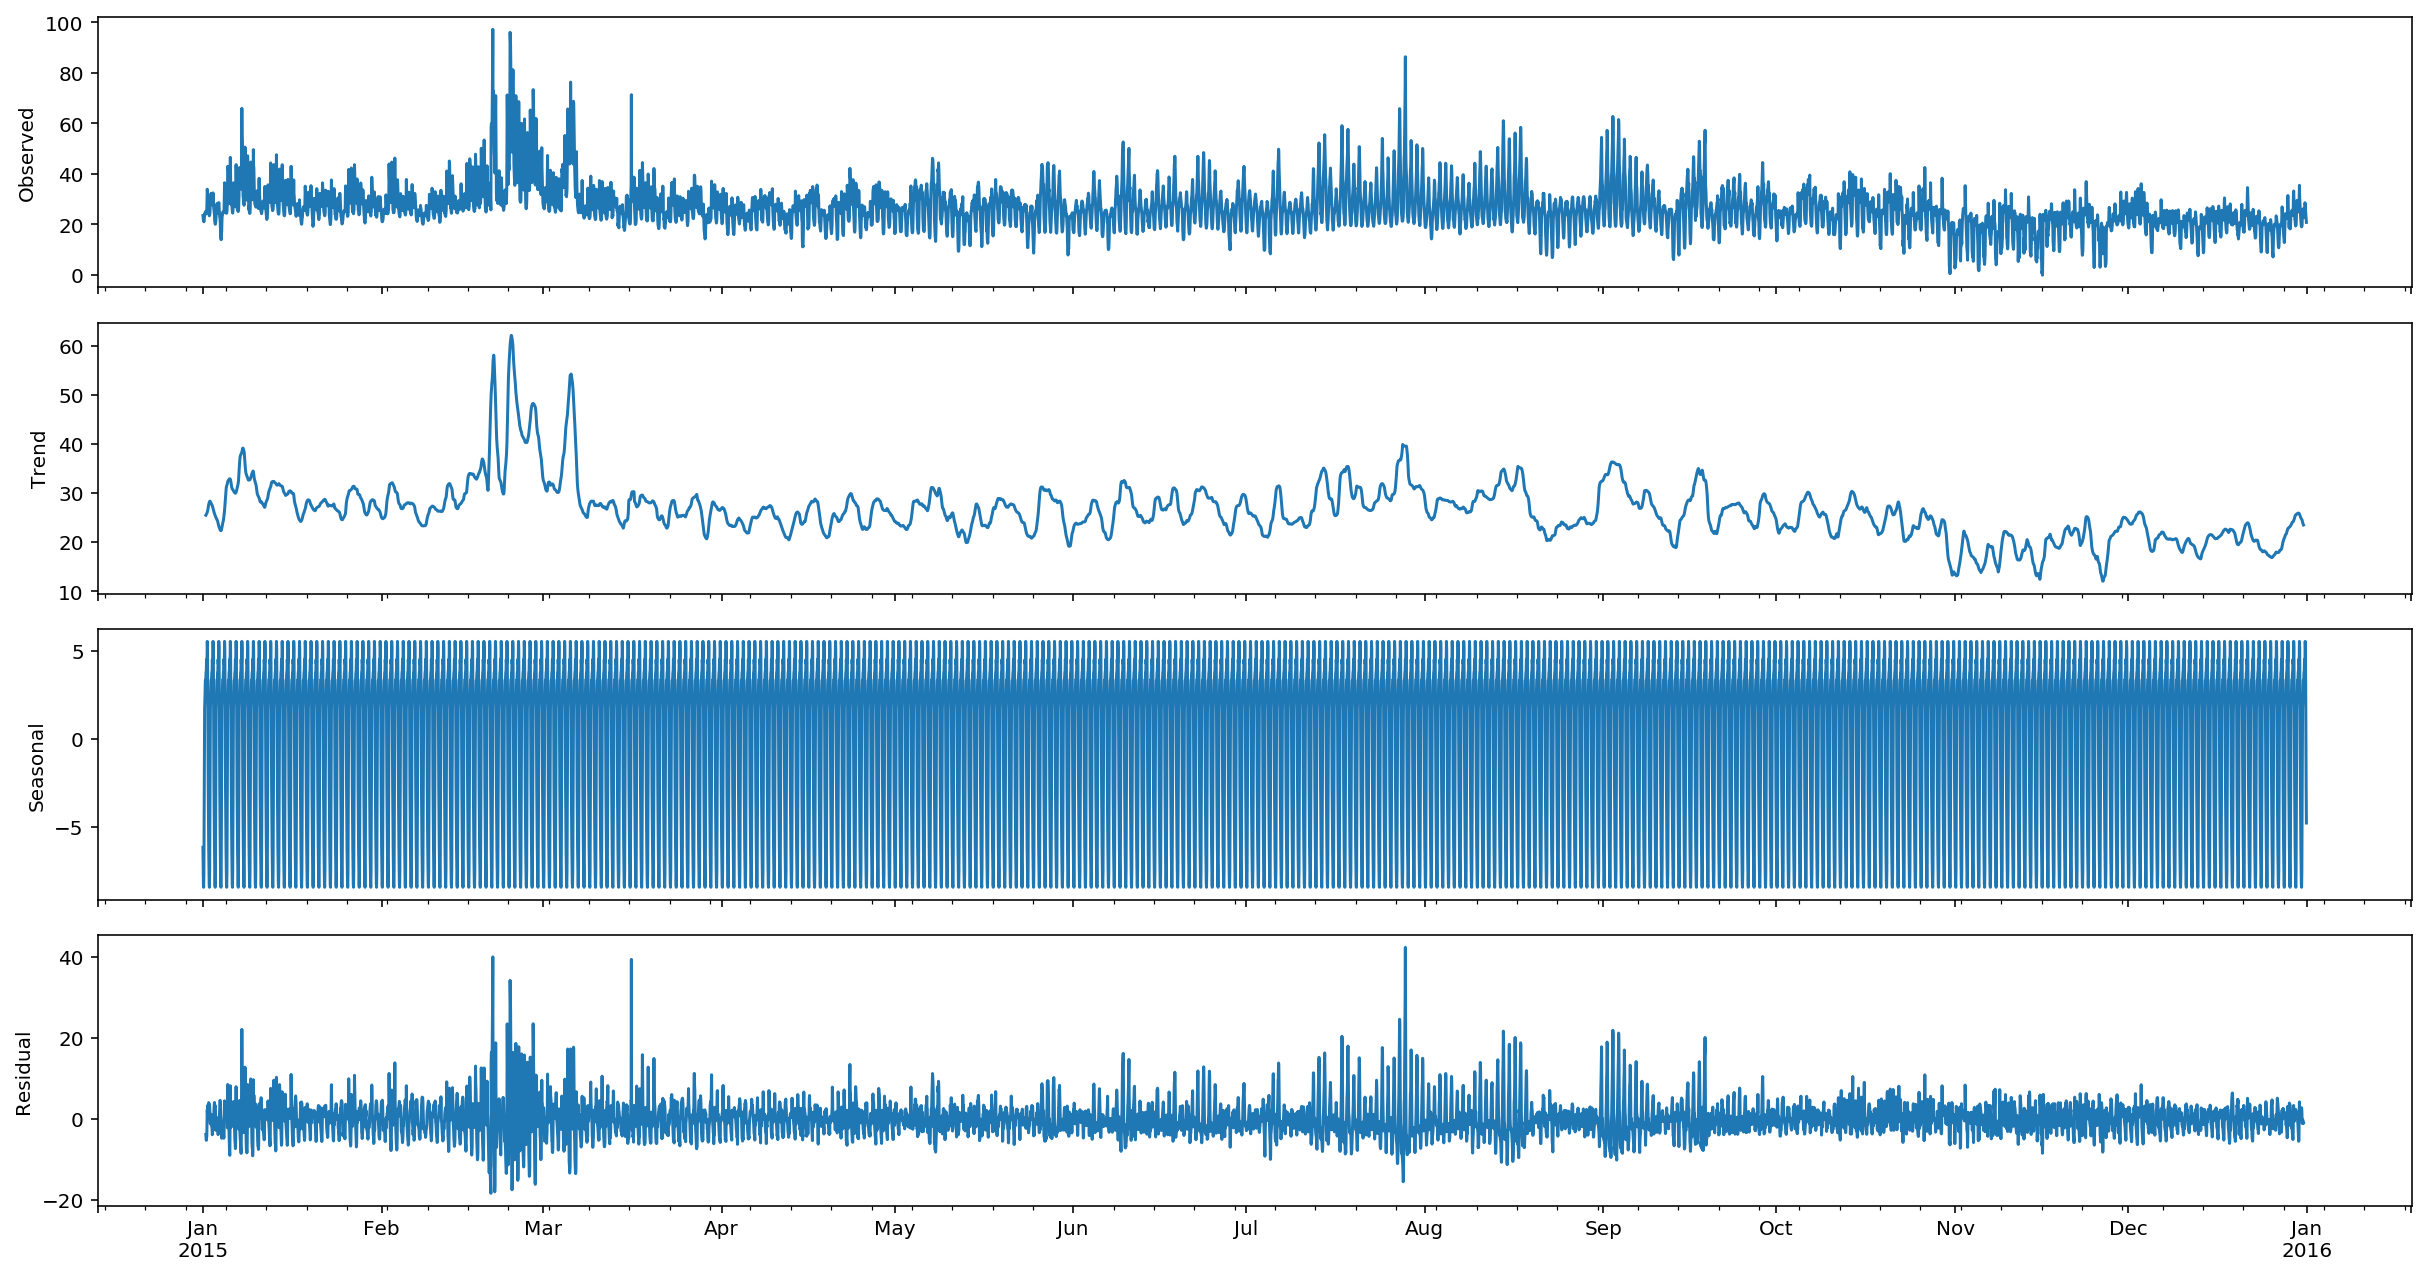

In [12]:
# So far we haven't really seen much indcation of an annual trend, though it
# seems somewhat counter intuitive from what I know of my own power bill
# through the years. In this case either the other two seasonal trends are
# drowning it out or there really isn't much difference in demand through the
# seasons at this node location.
seasonal_decompose(df['2015']['DA_LMP']).plot();

/Users/Arya/anaconda3/envs/dsi/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


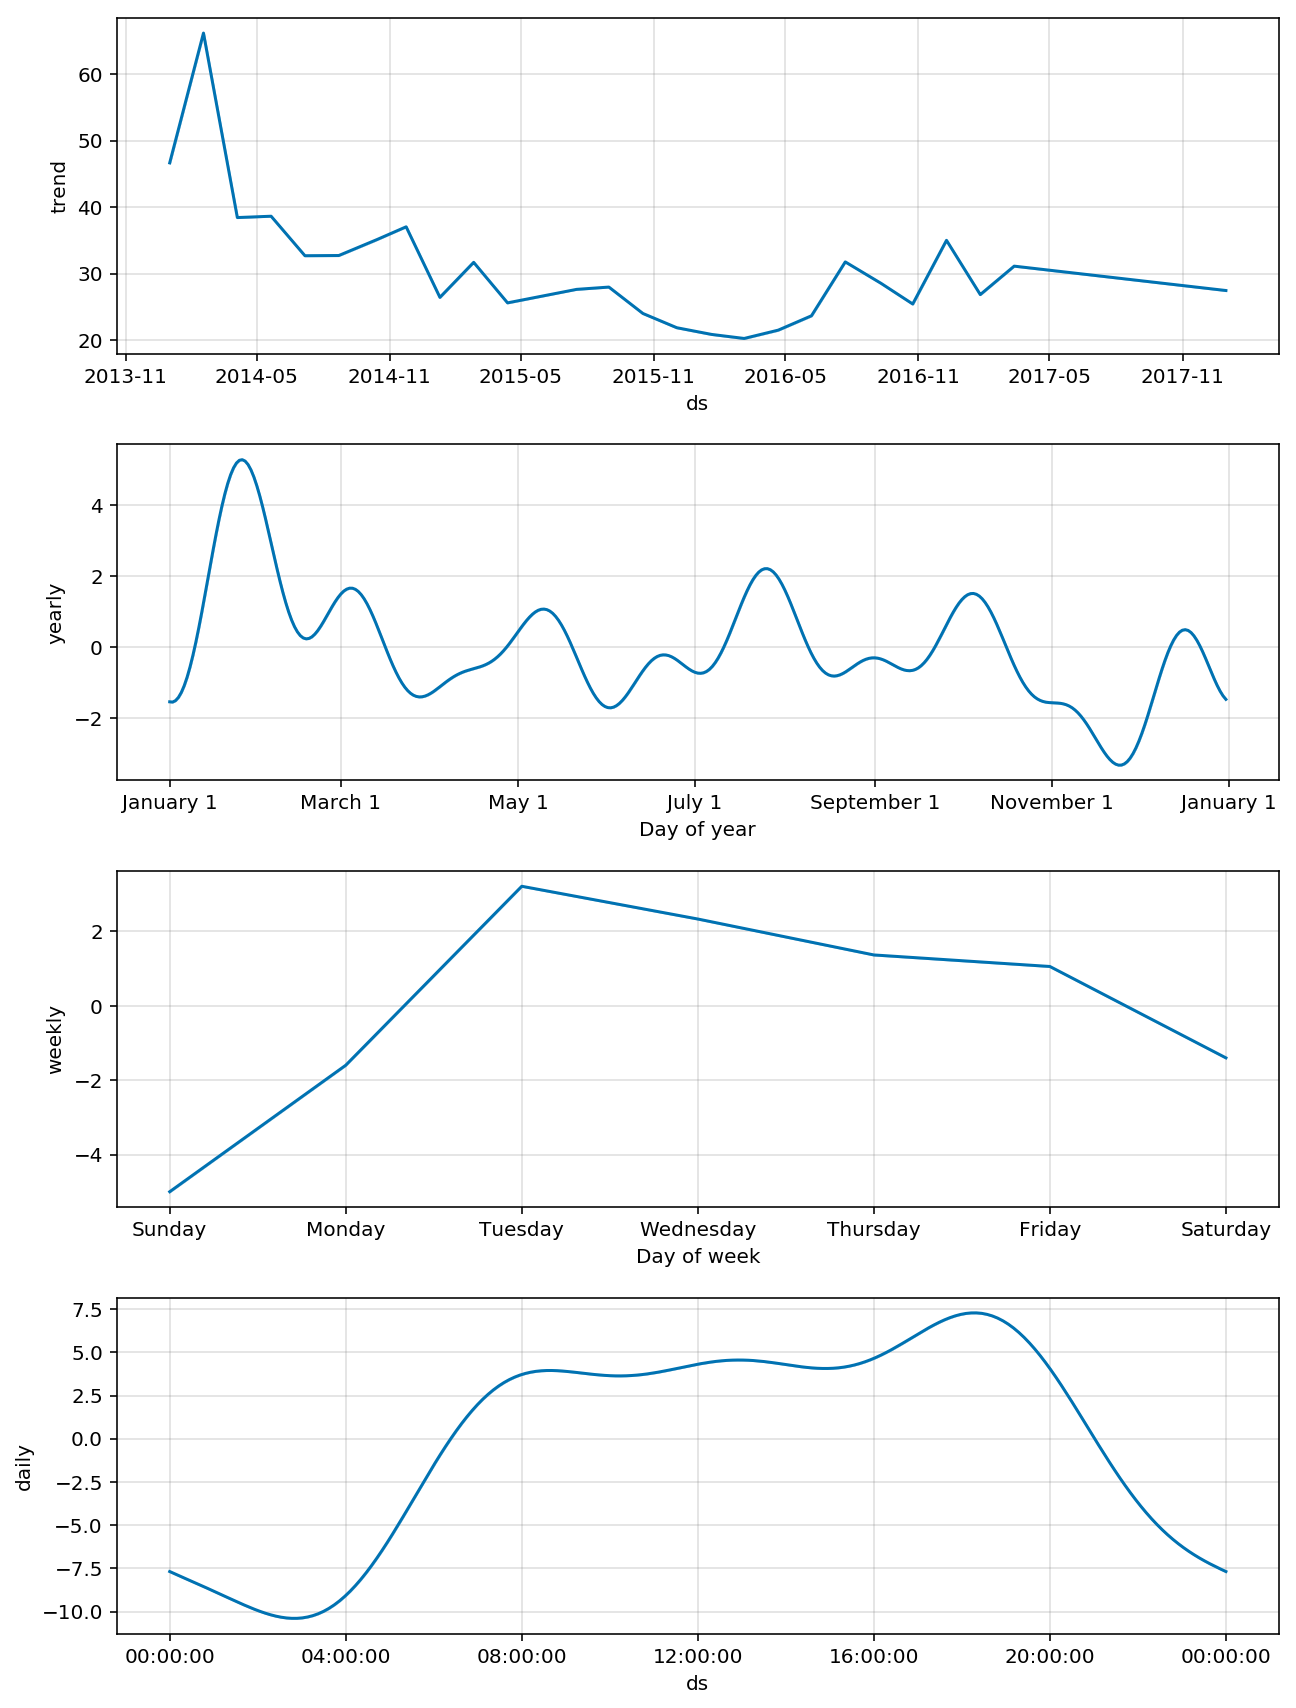

In [9]:
# Even Facebook's Prophet package which can detect multiple seasonal trends
# using Fourier series fails to find a meaningful annual trend. It's
# interesting to see that Sunday tends to have the lowest power demands.
prophetframe = pd.DataFrame()
prophetframe['ds'] = df.index
prophetframe['y'] = df['DA_LMP'].values
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.fit(prophetframe)
future = m.make_future_dataframe(1)
forecast = m.predict(future);
m.plot_components(forecast);

### 2) Stationarize the data

The next step is ensure the timeseries is stationary. The three conditions of stationarity are:

1) The mean of the series should not be a function of time,

2) The variance of the series should not vary with time (must be homoskedastic),

3) The covariance of the ith term and (i+m)th term should not be a function of time

The first condition is mostly fulfilled, so long as we are considering a substantial portion of the series, and the third condition is entirely met. Unfortunately the data is mildly heteroskedastic. There are methods to take this matter in stride such as log transforms, but instead I tried (and failed) to find the underlying cause by way of exogenous variables. In the future I would consider undertaking a transform method.

It is said that when dealing with trends or seasonality, one should consider taking a difference of the series. In the case of seasonal diffs, the value selected should be equal to the period in the data. In this case that leaves us with 24 for the daily trend and 168 for the weekly. A third option is a second order difference involving both values. I gave it a go, but ultimately the later models did not play very nice, especially with the diff(168) set and the second order series. It is also worth noting that none of the diffs I took were particularly effective at causing the autocorrelation function to fall and stay within the 95% confidence threshold in a brief number of lags.

For the sake of brevity I have removed the majority of the tests that proved redundant or useless, namely the second order diffs.

In [14]:
# Though it's typically for detrending, it's worth knowing the behavior since
# ARIMA modeling with d=1 is essentially the same as doing ARMA with diff(1)
diff1 = pd.Series(np.diff(df['DA_LMP'], n=1), index=df[1:].index)

In [18]:
diff24 = pd.Series(np.diff(df['DA_LMP'], n=24), index=df[24:].index)

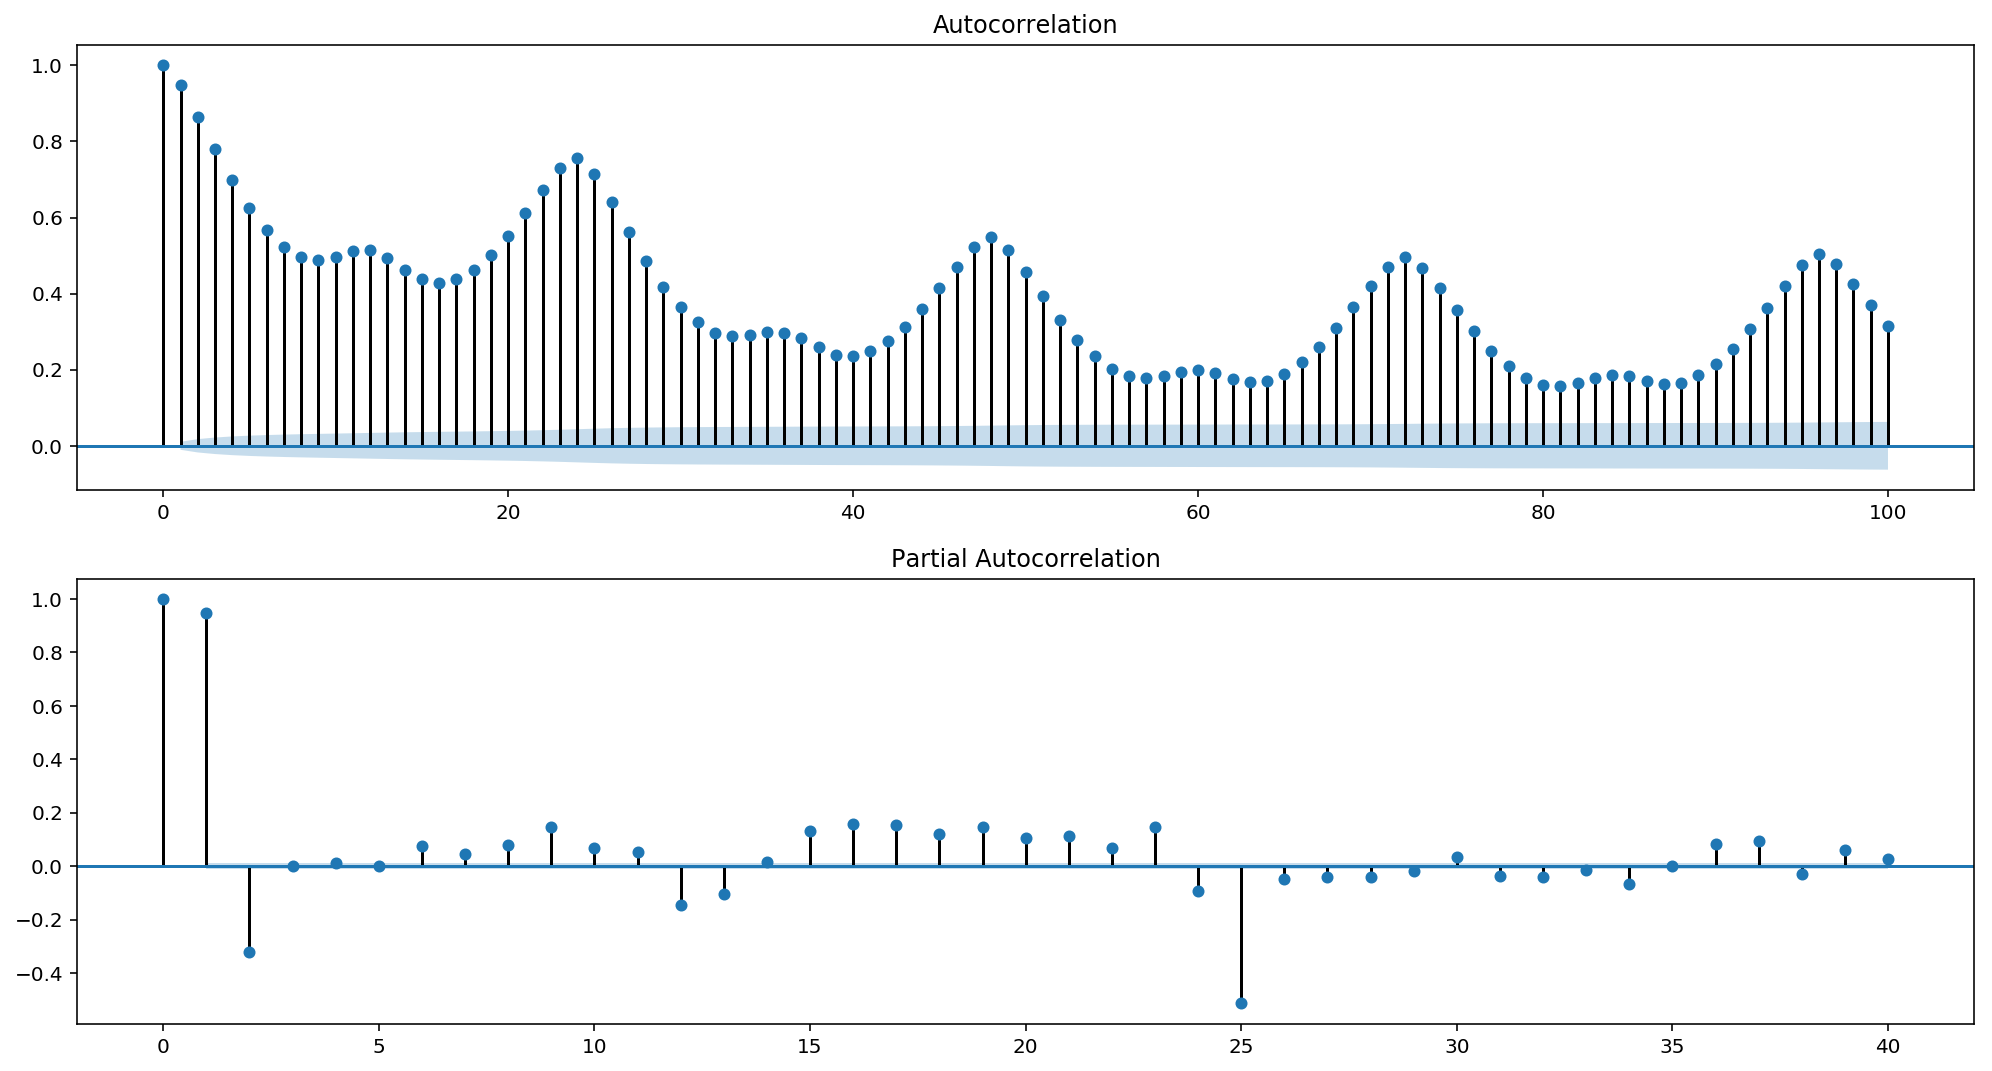

In [13]:
# Unsurprisingly time t and t-24 are most strongly correlated. What is odd is
# the slight bump every 12 hours. Also the prominence of the 15th lag in the pacf.
fig = plt.figure(figsize=(17,9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['DA_LMP'], lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['DA_LMP'], lags=40, ax=ax2)
plt.show()

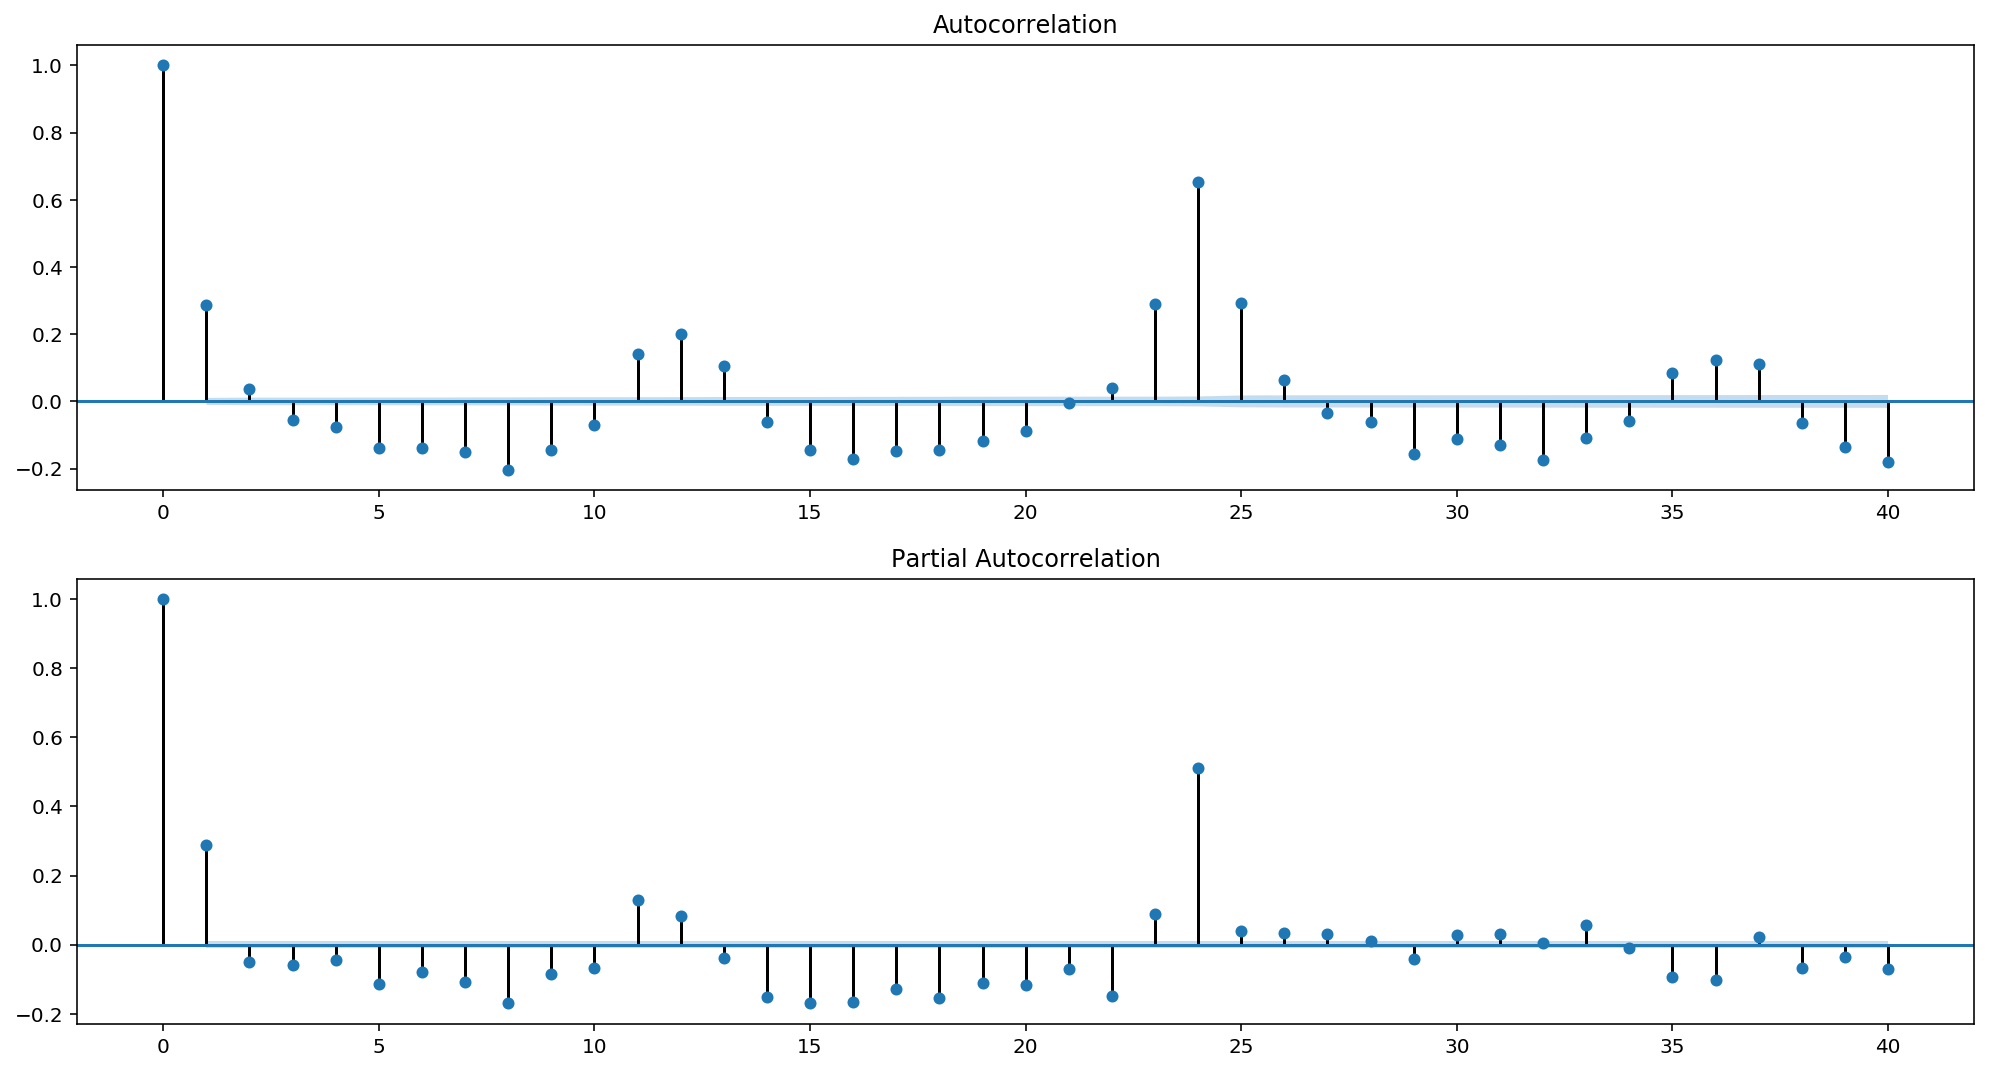

In [123]:
# Diff(1) - lags 12 and 24 are again the winners. Both correlations once again
# fail to converge in a timely fashion
fig = plt.figure(figsize=(17,9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1, lags=40, ax=ax2)
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


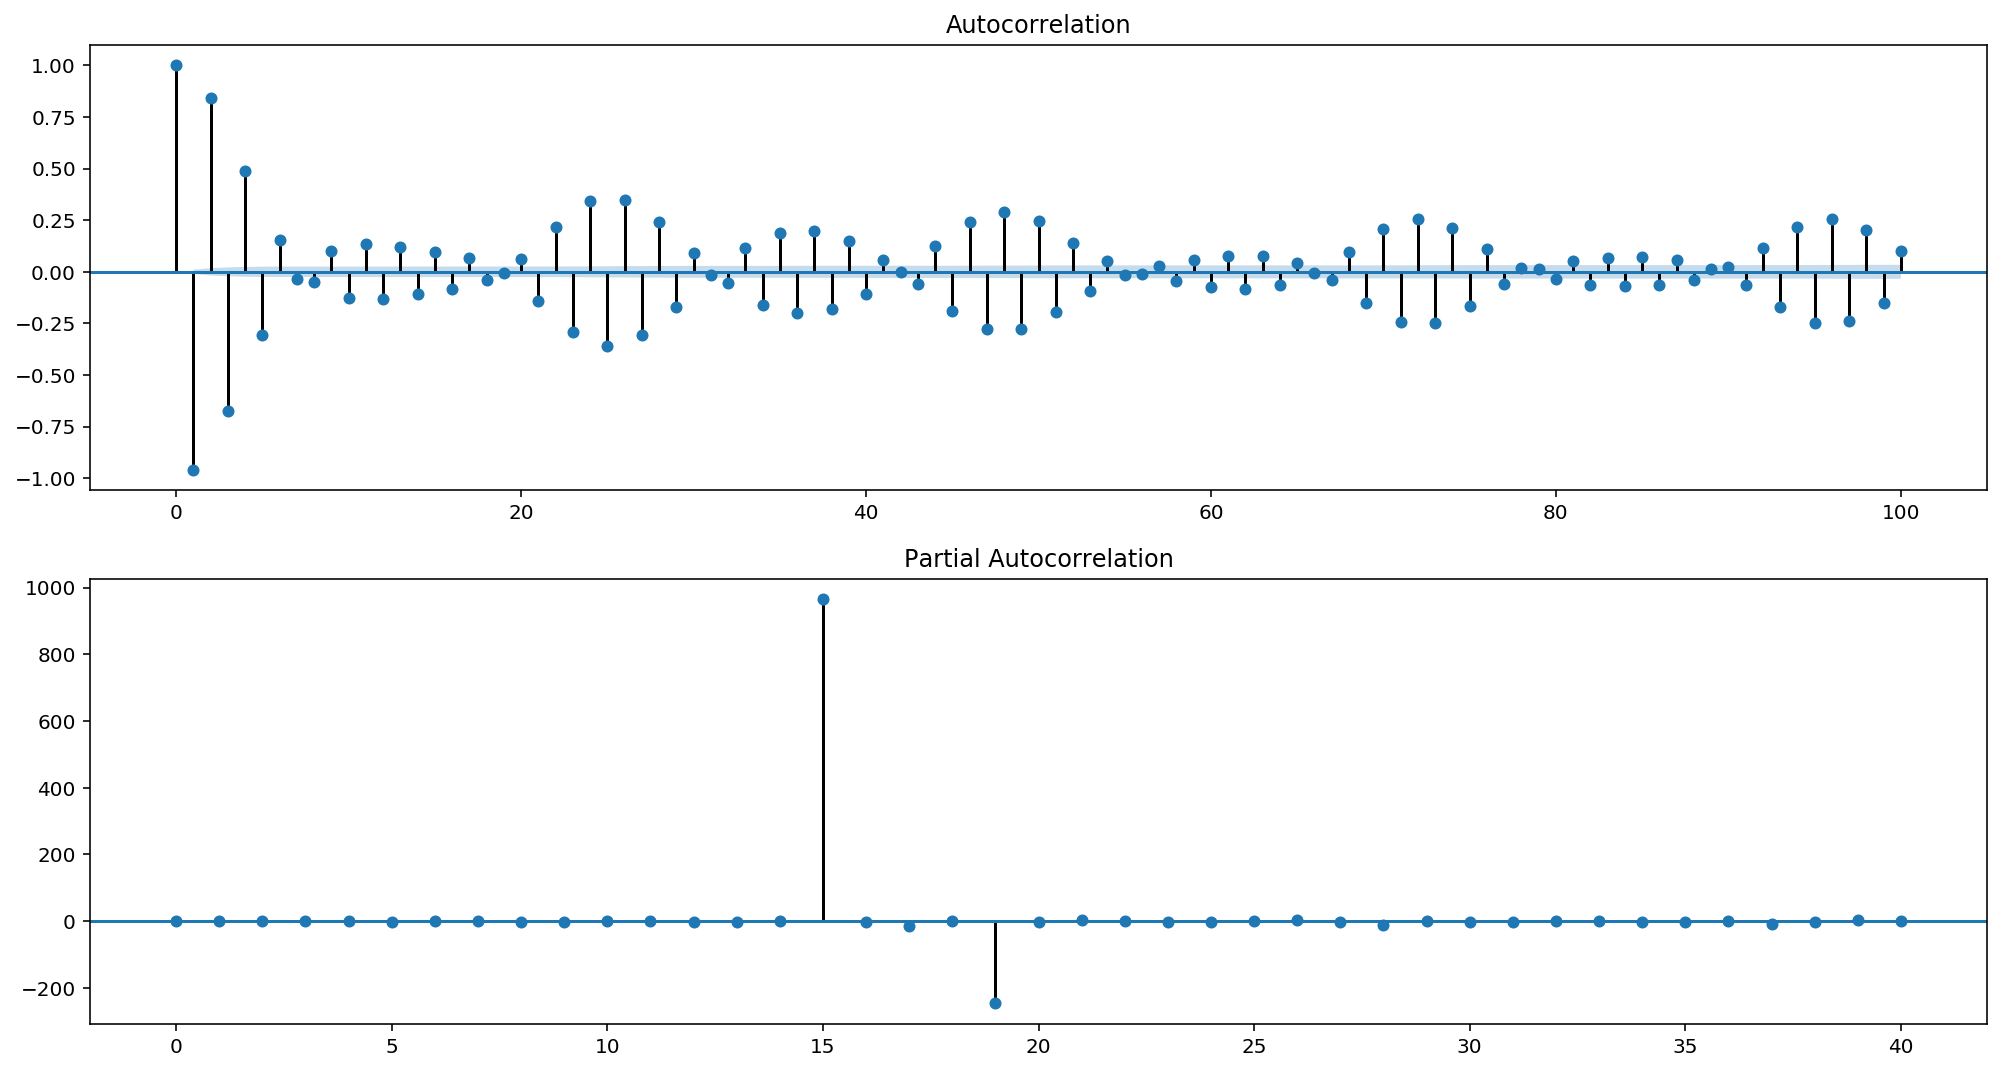

In [136]:
# Diff(24) - The pacf starts at 0 which I've never seen before. Meanwhile the
# acf fancies itself a self replicating organic nucleotide chain. In such a case
# the autocorrelation value would infact be very close to -1 as it alternates
# each lag. Oddly enough the autocorrelation functions for diff(168) and the
# second order differences very much resembled these charts.
fig = plt.figure(figsize=(17,9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff24, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff24, lags=40, ax=ax2)
plt.show()

#### ADF Stationarity Testing

Spoiler - All of the series tested were decidedly stationary. Despite the differenced series' tendency to have lower critical values across the board when compared to the non-differenced series, fitting models with them would often fail on the basis of them being considered non-stationary. I'm still not sure how that works.

In [131]:
# Plots and outputs relevant statistics for testing stationarity using augmented
# Dickey-Fuller test. Credit to J. Nelson for the implementation.

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=12,center=False).mean()
    rolstd = pd.Series.rolling(timeseries, window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In the augmented Dickey-Fuller test, the null hypothesis is the time series has a unit root. And the results that we get are a test statistic of -1.39 with a p-value of 0.38. Which is well below the 5% threshold so we say that we can’t reject the possibility of a unit root, which means we need to difference the series and then produce our autocorrelation plots. It’s just a minor change to the code.

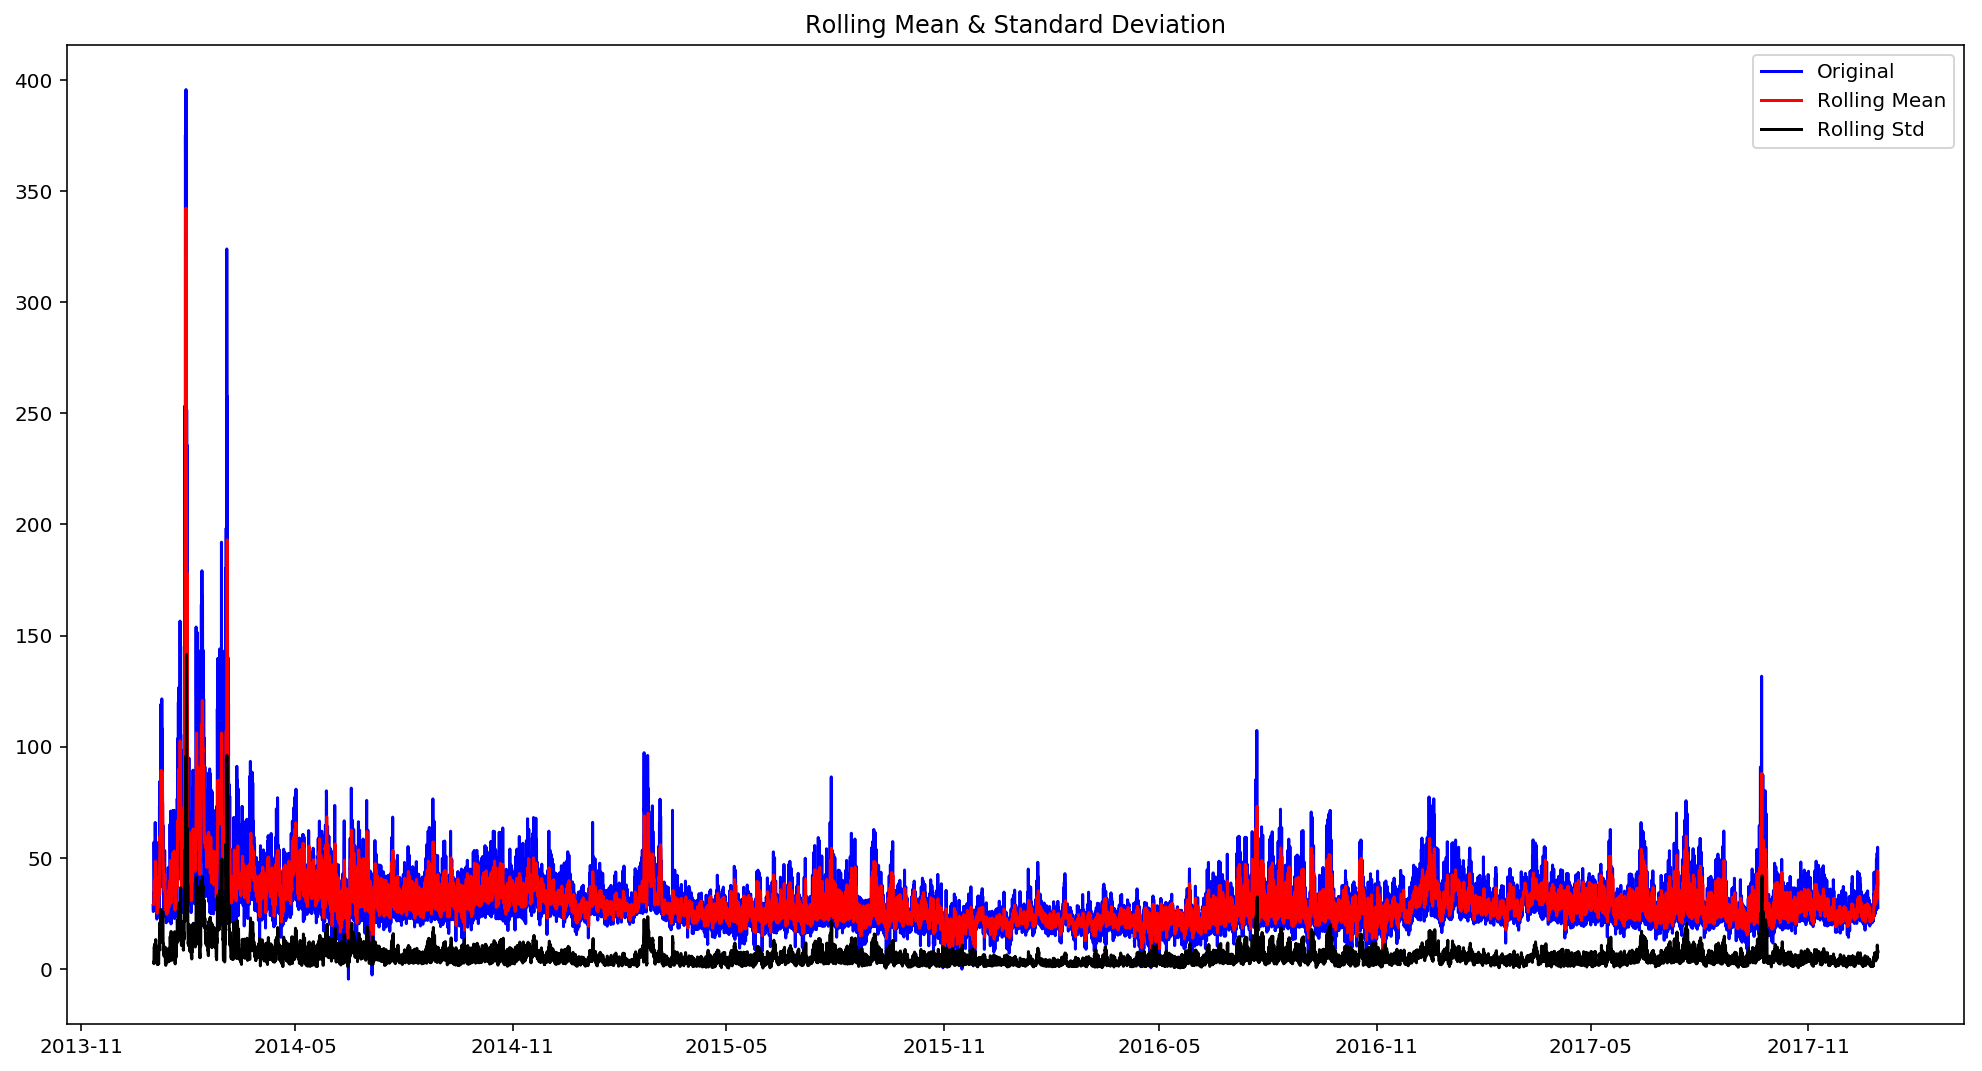

Results of Dickey-Fuller Test:
Test Statistic                -1.349804e+01
p-value                        3.014892e-25
#Lags Used                     5.200000e+01
Number of Observations Used    3.496300e+04
Critical Value (1%)           -3.430537e+00
Critical Value (5%)           -2.861623e+00
Critical Value (10%)          -2.566814e+00
dtype: float64


In [156]:
# With a test statistic of -13.50 falling well below the 1% critical value of
# -3.43, we handily reject the null hypothesis that the series has a unit root.
test_stationarity(df['DA_LMP'])

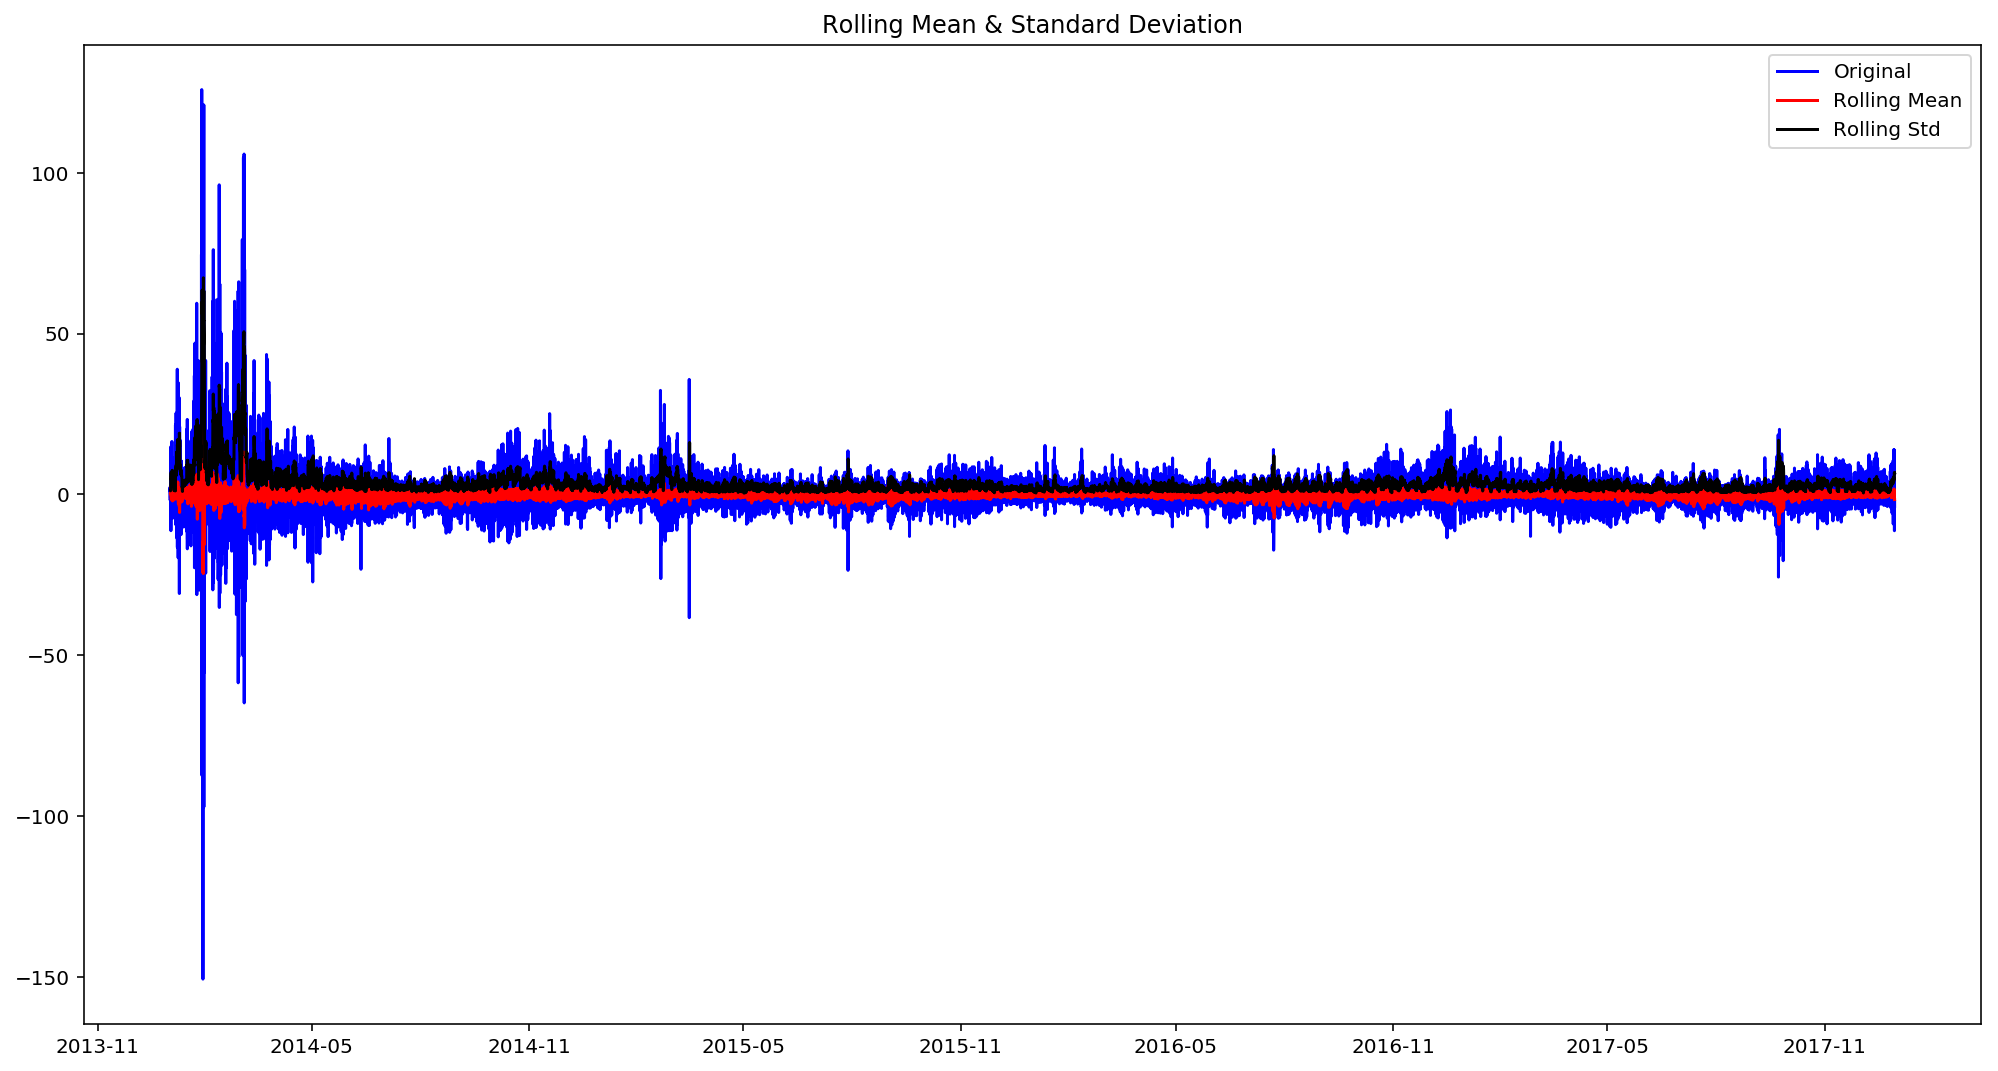

Results of Dickey-Fuller Test:
Test Statistic                   -33.563991
p-value                            0.000000
#Lags Used                        51.000000
Number of Observations Used    34963.000000
Critical Value (1%)               -3.430537
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64


In [158]:
# Once again, the null-hypothesis is easily rejected, at least according to
# the test.
test_stationarity(df['DA_LMP'].diff()[1:])

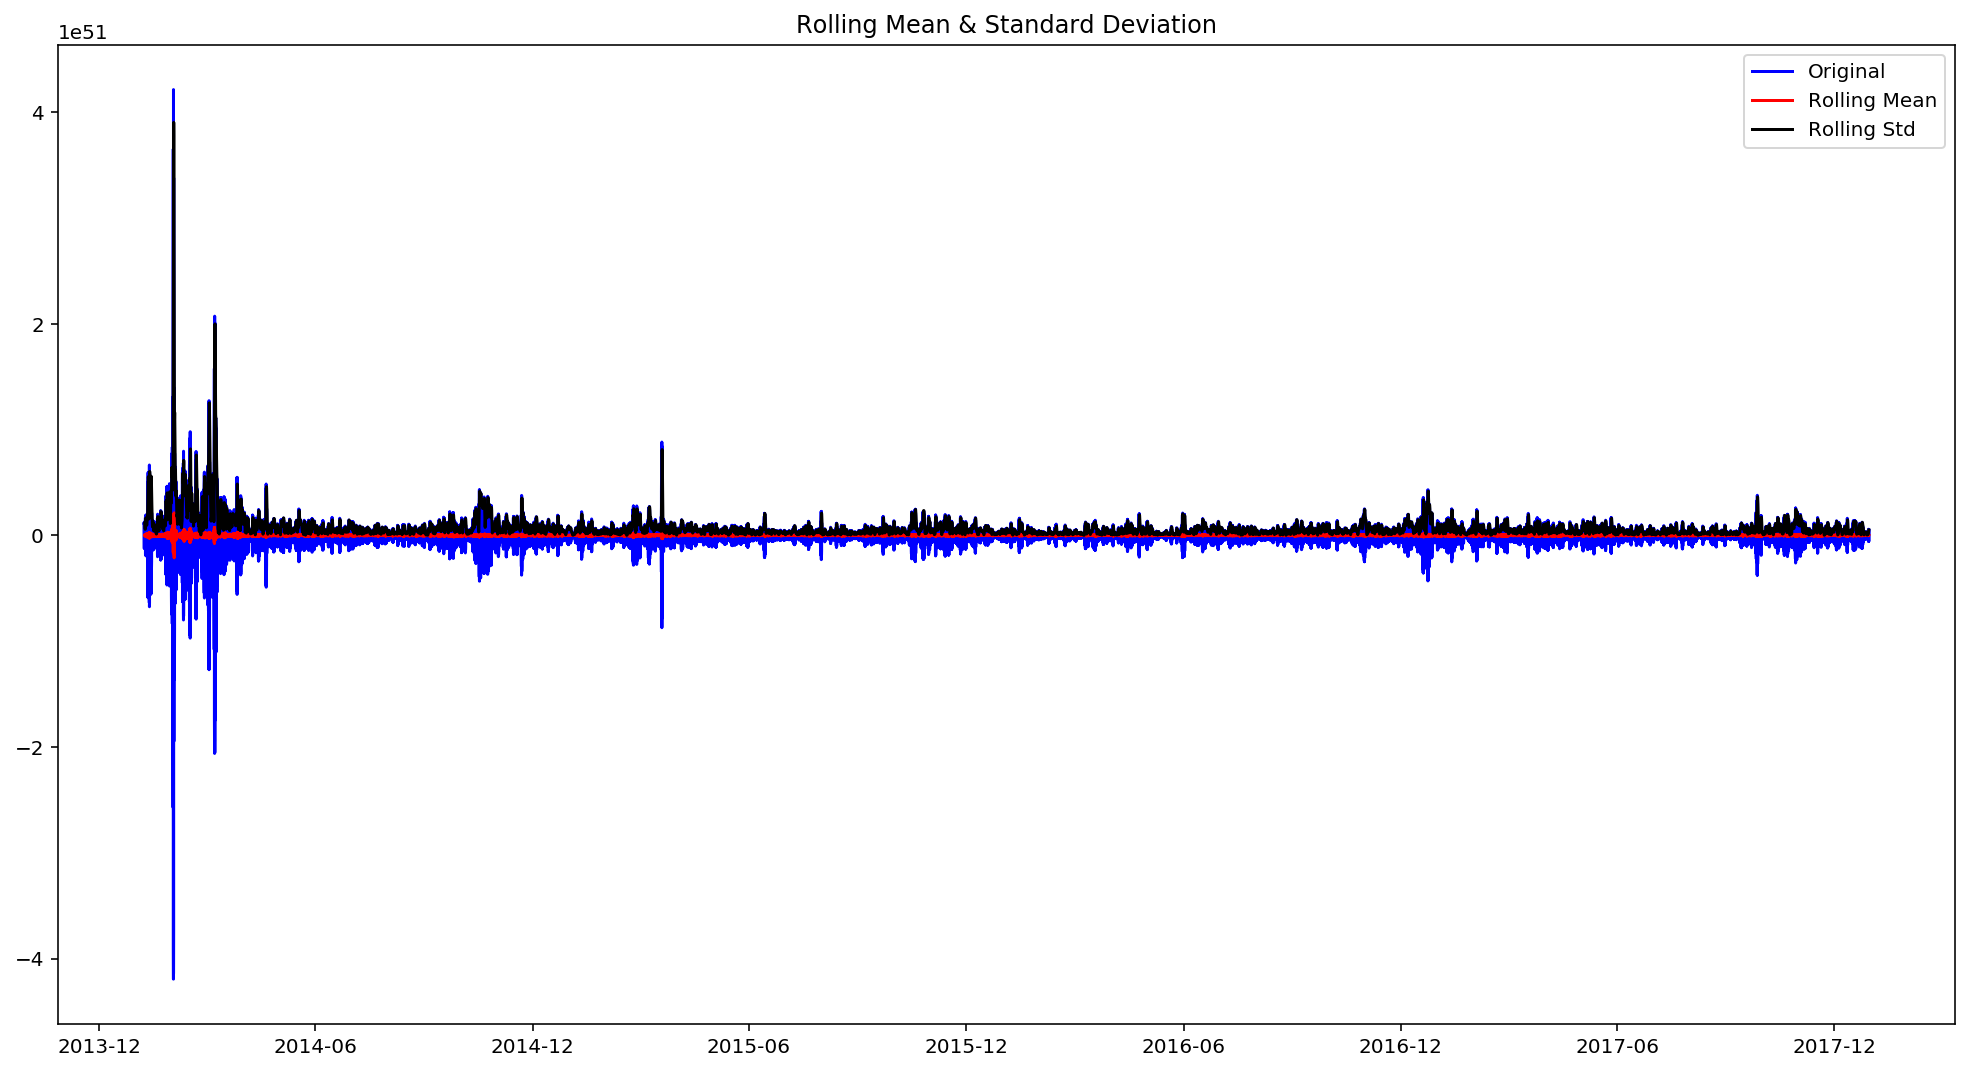

Results of Dickey-Fuller Test:
Test Statistic                 -1220.405982
p-value                            0.000000
#Lags Used                         9.000000
Number of Observations Used    34838.000000
Critical Value (1%)               -3.430538
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64


In [166]:
# And again...
test_stationarity(diff168)

### 3a) Assess optimal parameters - ARMA

If we refer back to acf and pacf graphs above, we can see that there aren't many particular values that stand out as having the potential of being an optimal parameter for an ARMA model. My understanding is that having multiple seasonal trends can hamper acf and pacf convergence, but unfortunately Python is missing many of the timeseries tools that would resolve cases like this. For the future, I would probably set aside some time to learn R for TS modeling.

In the absence of clear parameters, I opted for a grid search. Unfortunately I found that no matter how high the parameters went, they remained significant to the model. With computational power being the bottle neck, I had to give up and move on, but I found some interesting trends along the way.

In [4]:
# ARMA gridsearch - iterates through given p and q values printing the
# sum of squared errors. Prints best configuration & error score and
# returns a list of the SSE terms.

def arma_gs(dataset, p_values, q_values):
    history = list()
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for q in q_values:
            order = (p, q)
            try:
                model = ARMA(dataset, order)
                results = model.fit(disp=-1)
                sse = sum((results.fittedvalues - dataset) ** 2)
                if sse < best_score:
                    best_score, best_cfg = sse, order
                print('ARMA%s SSE=%.0f' % (order,sse))
                history.append(sse)
            except:
                continue
    print('Best ARMA%s SSE=%.0f' % (best_cfg, best_score))
    return(pd.Series(history))

##### AR gridsearch and plotting

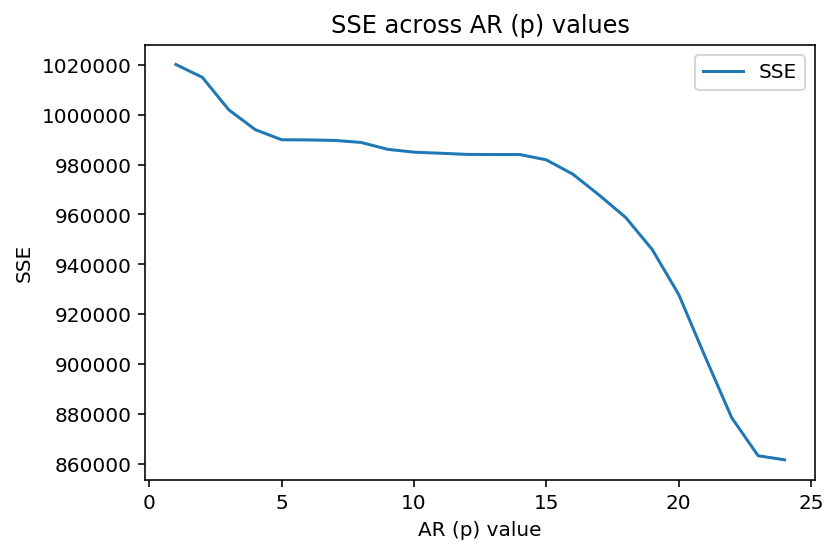

In [50]:
# As AR increases, SSE decreases, but it's the later lags that really make the
# difference (up to 24)
plt.plot(ar_hist[1:], label='SSE')
plt.xlabel('AR (p) value')
plt.ylabel('SSE')
plt.title('SSE across AR (p) values')
plt.legend();

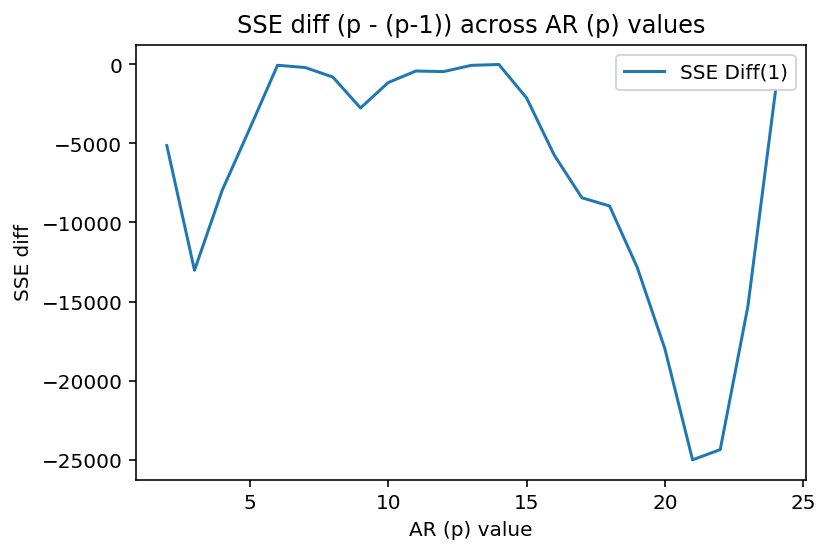

In [51]:
# I didn't go beyond p=24, but if I had to guess, the graph would have likely
# repeated a similar pattern, but more subdued.
plt.plot(ar_hist.diff()[2:], label='SSE Diff(1)');
plt.xlabel('AR (p) value')
plt.ylabel('SSE diff')
plt.title('SSE diff (p - (p-1)) across AR (p) values')
plt.legend();

##### MA gridsearch and plotting

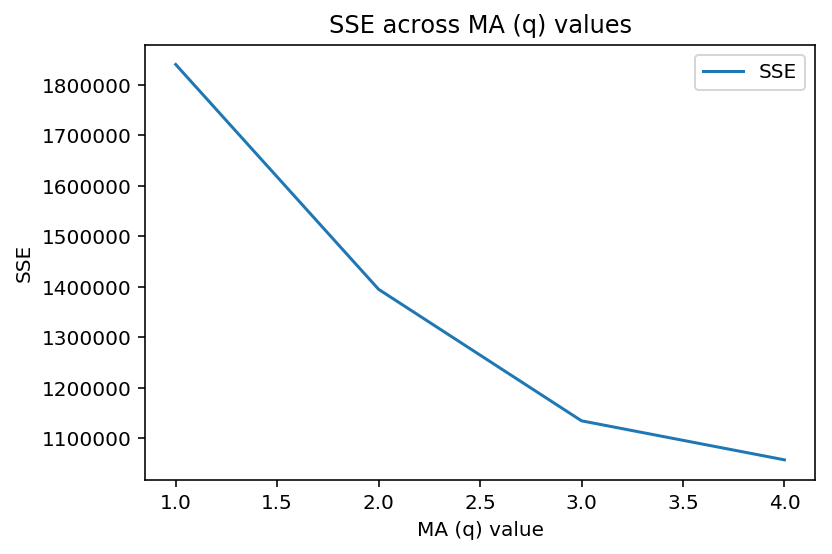

In [41]:
# The MA model failed to converge past q=4 when p=0. Later in ARMA models though,
# higher q values could be used so long as p was also rising.
plt.plot(ma_hist[1:], label='SSE')
plt.xlabel('MA (q) value')
plt.ylabel('SSE')
plt.title('SSE across MA (q) values')
plt.legend();

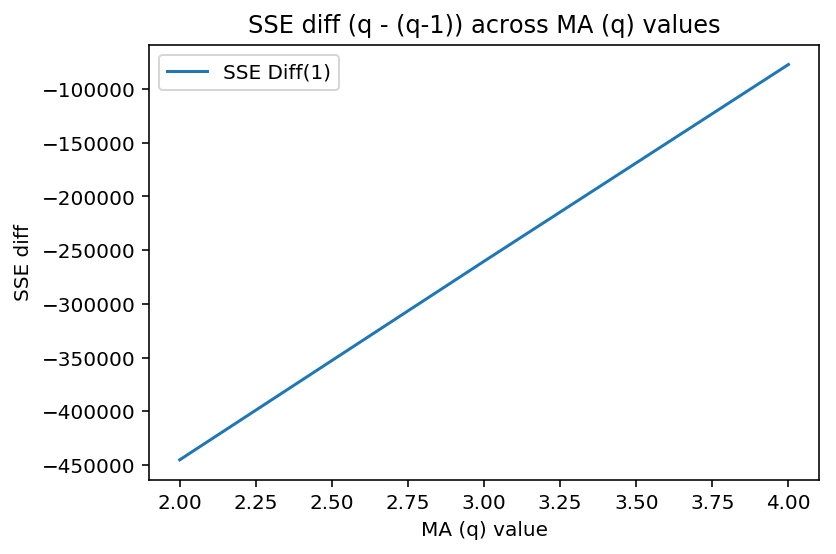

In [56]:
# The benefit to our loss function for MA is perfectly linear so long as p=0
plt.plot(ma_hist.diff()[2:], label='SSE Diff(1)');
plt.xlabel('MA (q) value')
plt.ylabel('SSE diff')
plt.title('SSE diff (q - (q-1)) across MA (q) values')
plt.legend();

##### ARMA grid search and plotting

The next few graphs show how our MA term affected our loss function as we changed p: as p increased, the q value had to also be higher to make a noticeable impact, but when it finally kicked it, it would essentially make up for lost time and lose its linear benefit in favor of a more aggressive descent.

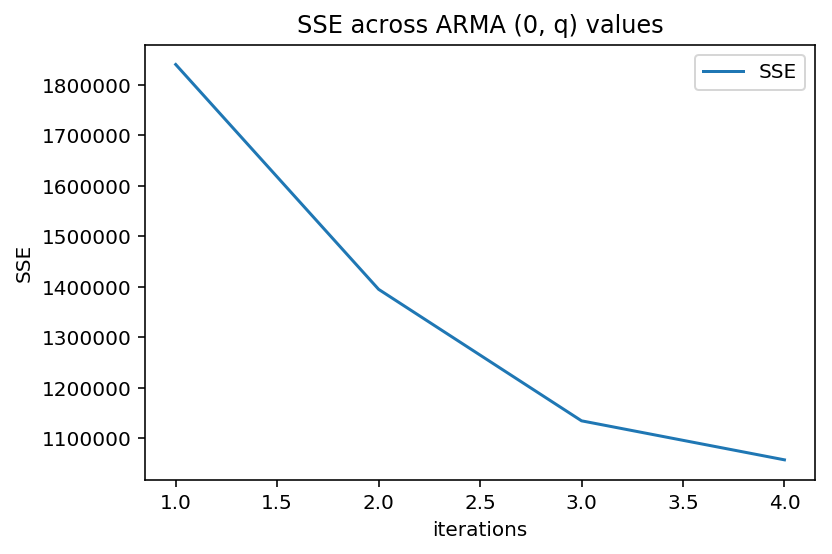

In [75]:
# Just the SSEs for p=0
plt.plot(arma_hist[1:5], label='SSE')
plt.xlabel('iterations')
plt.ylabel('SSE')
plt.title('SSE across ARMA (0, q) values')
plt.legend();

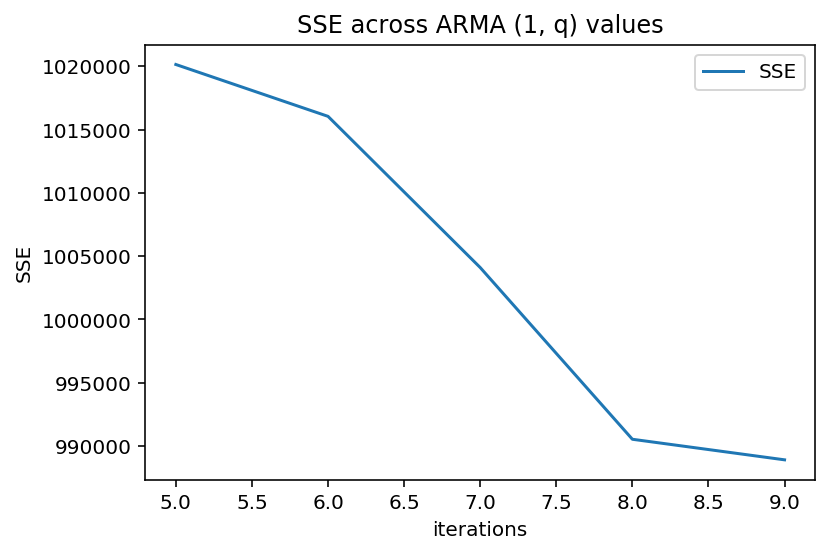

In [76]:
# Just the SSEs for p=1
plt.plot(arma_hist[5:10], label='SSE')
plt.xlabel('iterations')
plt.ylabel('SSE')
plt.title('SSE across ARMA (1, q) values')
plt.legend();

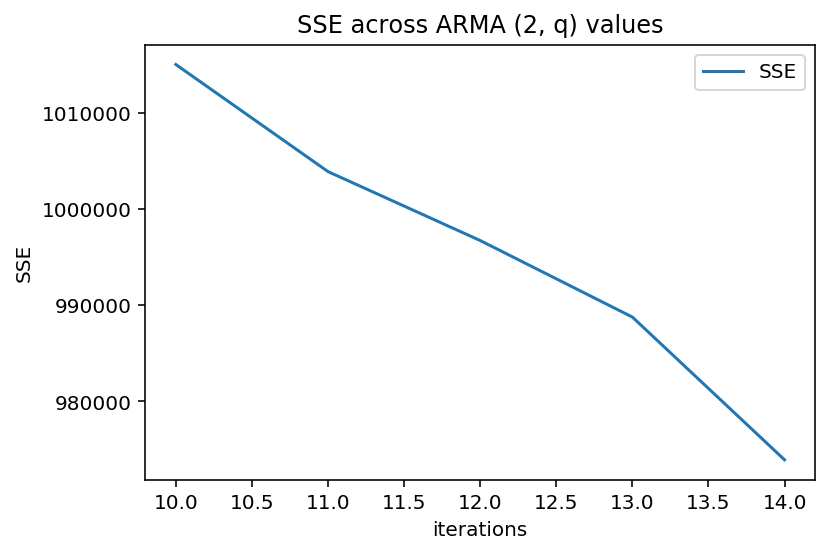

In [77]:
# Just the SSEs for p=2
plt.plot(arma_hist[10:15], label='SSE')
plt.xlabel('iterations')
plt.ylabel('SSE')
plt.title('SSE across ARMA (2, q) values')
plt.legend();

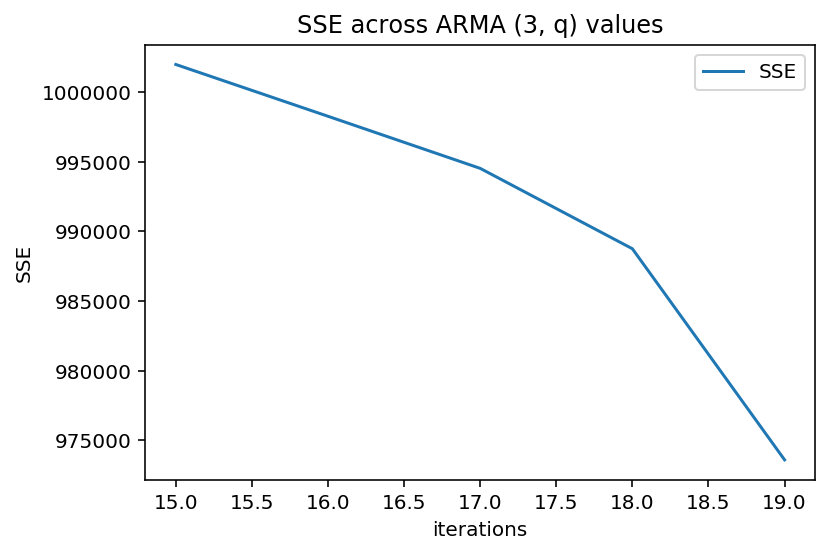

In [78]:
# Just the SSEs for p=3
plt.plot(arma_hist[15:20], label='SSE')
plt.xlabel('iterations')
plt.ylabel('SSE')
plt.title('SSE across ARMA (3, q) values')
plt.legend();

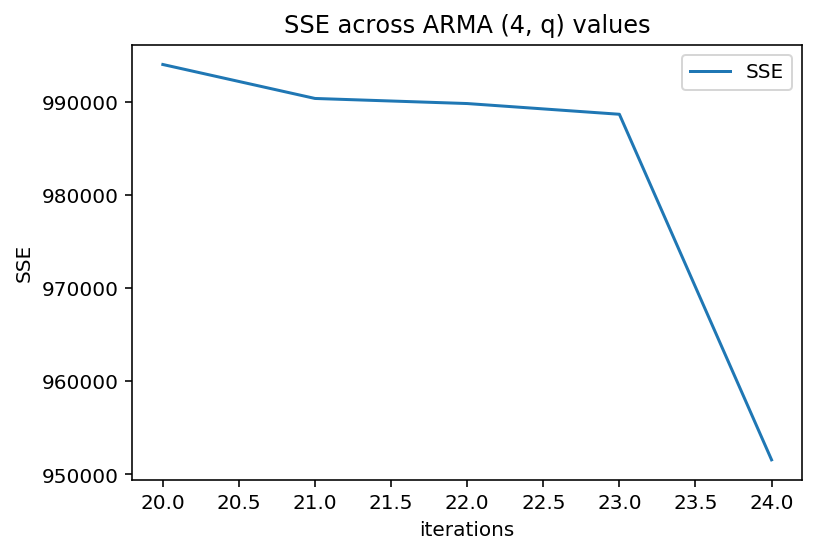

In [79]:
# Just the SSEs for p=4
plt.plot(arma_hist[20:25], label='SSE')
plt.xlabel('iterations')
plt.ylabel('SSE')
plt.title('SSE across ARMA (4, q) values')
plt.legend();

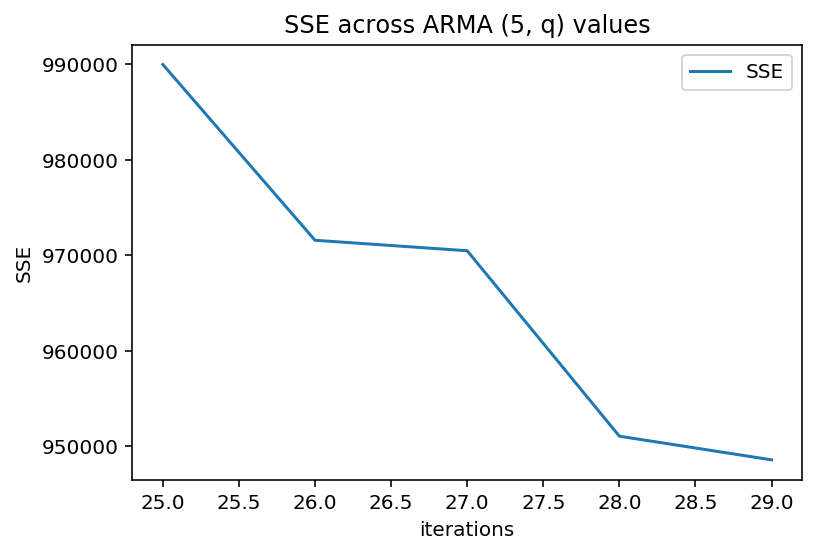

In [211]:
# Just the SSEs for p=5
plt.plot(arma_hist[25:], label='SSE')
plt.xlabel('iterations')
plt.ylabel('SSE')
plt.title('SSE across ARMA (5, q) values')
plt.legend();

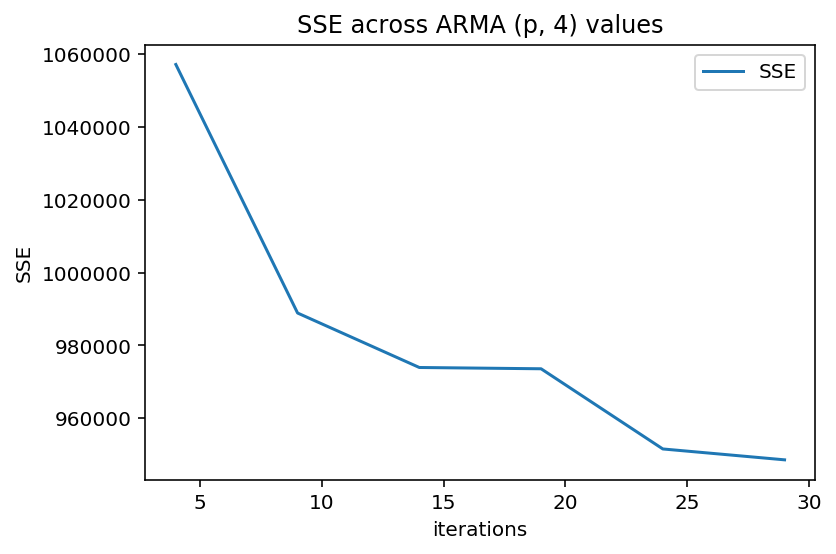

In [103]:
# As before, the benefit of the q term levels off close to lag 24
plt.plot(arma_hist[4::5], label='SSE')
plt.xlabel('iterations')
plt.ylabel('SSE')
plt.title('SSE across ARMA (p, 4) values')
plt.legend();

### 3b) Assess optimal parameters - ARIMA

While the key metric (SSE) used in this grid search is the same as that above, in this case it is calculated against the differenced dataset. This means that the scores can only be interpreted within the context of the same model.

In [5]:
# ARIMA gridsearch - iterates through given p, d, and q values printing the
# sum of squared errors. Prints best configuration & error score and
# returns a list of the SSE terms.

def arima_gs(dataset, p_values, d_values, q_values):
    history = list()
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(dataset, order)
                    results = model.fit(disp=-1)
                    sse = sum(((results.fittedvalues - dataset.diff())[d:]) ** 2)
                    if sse < best_score:
                        best_score, best_cfg = sse, order
                    print('ARIMA%s SSE=%.0f' % (order,sse))
                    history.append(sse)
                except:
                    continue
    print('Best ARIMA%s SSE=%.0f' % (best_cfg, best_score))
    return(pd.Series(history))

##### ARI grid search and plotting

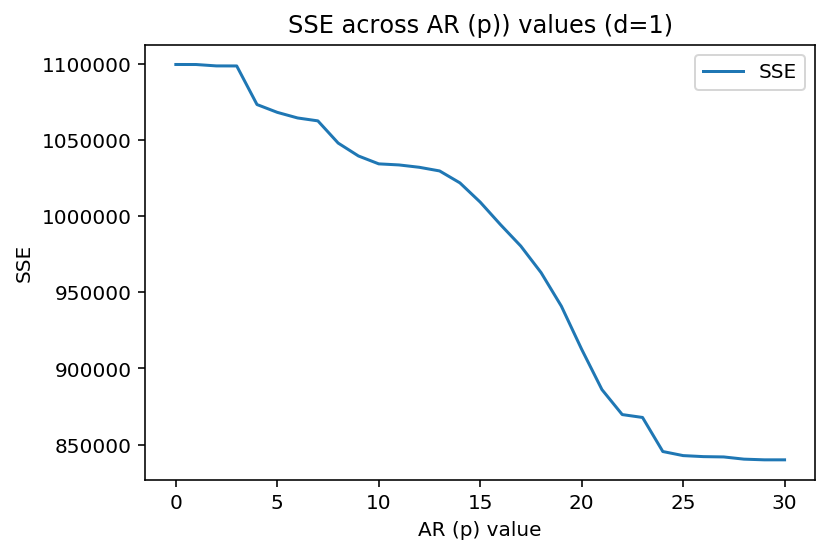

In [208]:
# Just as before, the AR term loses its spark around lag 24
plt.plot(ari_hist, label='SSE')
plt.xlabel('AR (p) value')
plt.ylabel('SSE')
plt.title('SSE across AR (p)) values (d=1)')
plt.legend();

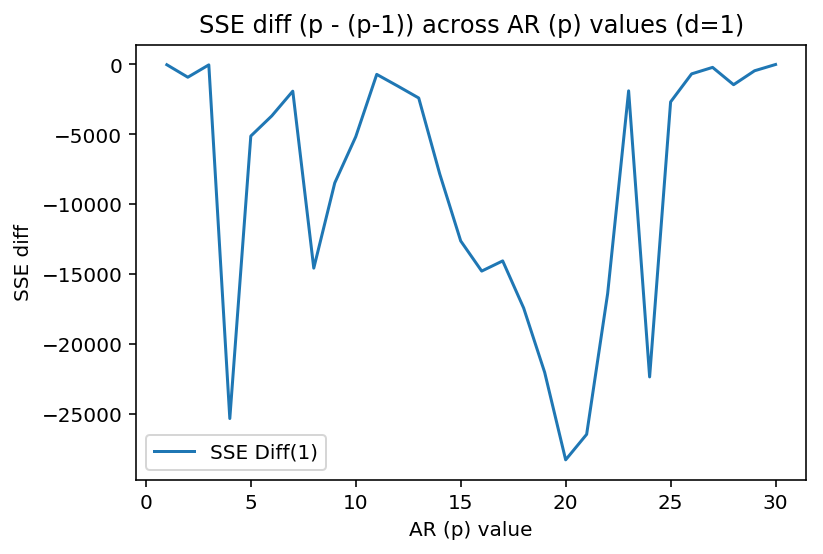

In [209]:
plt.plot(ari_hist.diff()[1:], label='SSE Diff(1)');
plt.xlabel('AR (p) value')
plt.ylabel('SSE diff')
plt.title('SSE diff (p - (p-1)) across AR (p) values (d=1)')
plt.legend();

##### IMA grid search and plotting

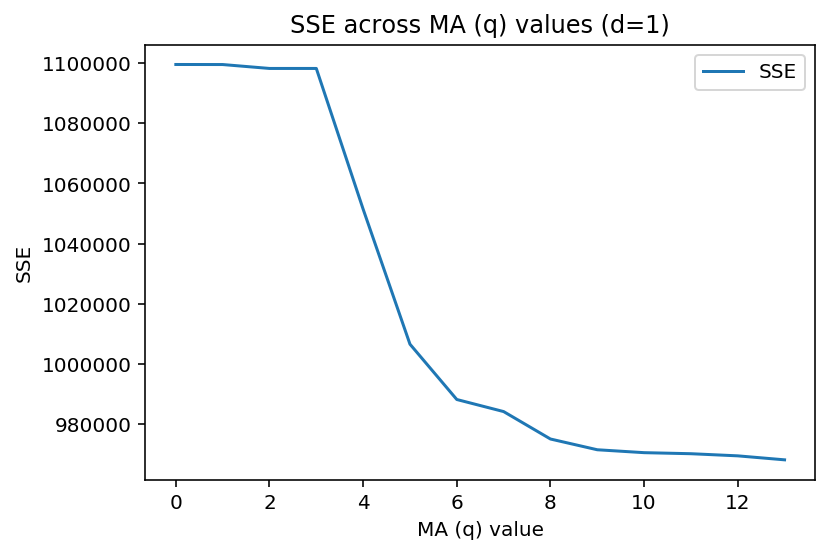

In [203]:
# The model fails to converge past q=13 when p = 0
plt.plot(ima_hist, label='SSE')
plt.xlabel('MA (q) value')
plt.ylabel('SSE')
plt.title('SSE across MA (q) values (d=1)')
plt.legend();

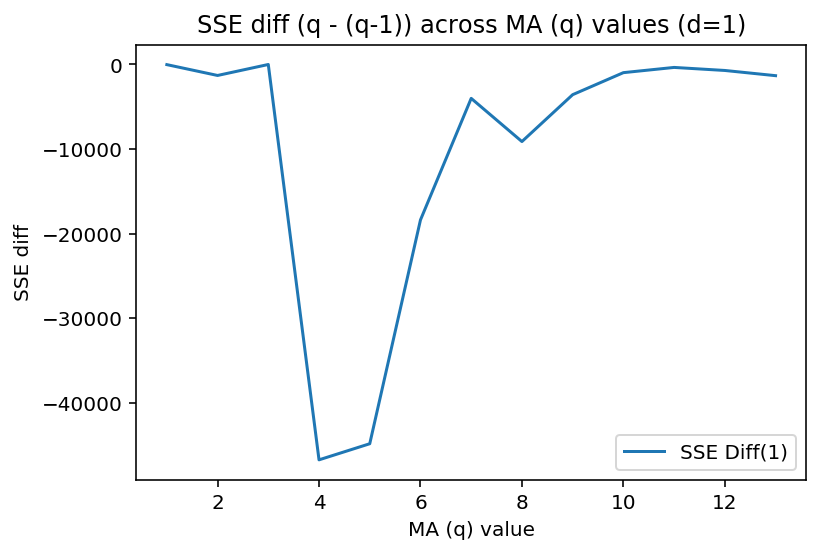

In [204]:
# Unilke before, the relationship between the q value and the loss function
# is far from linear in this case
plt.plot(ima_hist.diff()[1:], label='SSE Diff(1)');
plt.xlabel('MA (q) value')
plt.ylabel('SSE diff')
plt.title('SSE diff (q - (q-1)) across MA (q) values (d=1)')
plt.legend();

#### ARIMA grid search and plotting

The visualizations for this part were unfortunately lost, however the best performing parameters found before the computational overhead became untenable was ARIMA(10, 1, 6). That being said, the loss function was still falling when the kernel crashed. It is plausible and in fact likely by my estimation that higher values could have helped the fit further.

#### SARIMA grid search

Ultimately SARIMA provided the best fit model for this particular dataset. The grid search values were preserved as output. SARIMA(2, 0, 4)x(1, 1, 1, 24) performed nearly as well as the computationally more expensive SARIMA(4, 0, 4)x(1, 1, 1, 24). Attempts to grid search beyond these values caused the kernel to crash consistently. Also attempts to set s = 168 to capture the weekly trends caused memory errors, possibly due to a bug in the L-BFGS-B optimizer.

In [35]:
p_values = range(0, 5)
d_values = [0]
q_values = range(0, 5)

pdq = list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            order.append((p,d,q))
            
seasonal_pdq = [(1, 1, 1, 24)]

In [10]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df['DA_LMP'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{} - AIC:{} - LL:{}'.format(param, param_seasonal, results.aic, results.llf))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 24)24 - AIC:346397.2810765137 - LL:-173197.64053825685
SARIMA(0, 0, 0)x(0, 0, 1, 24)24 - AIC:310576.8845846541 - LL:-155286.44229232706
SARIMA(0, 0, 0)x(0, 1, 0, 24)24 - AIC:265518.39969857584 - LL:-132758.19984928792
SARIMA(0, 0, 0)x(0, 1, 1, 24)24 - AIC:264559.484827951 - LL:-132277.7424139755
SARIMA(0, 0, 0)x(1, 0, 0, 24)24 - AIC:264645.6932357314 - LL:-132320.8466178657
SARIMA(0, 0, 0)x(1, 0, 1, 24)24 - AIC:264312.763111901 - LL:-132153.3815559505
SARIMA(0, 0, 0)x(1, 1, 0, 24)24 - AIC:265153.48751293414 - LL:-132574.74375646707
SARIMA(0, 0, 0)x(1, 1, 1, 24)24 - AIC:257306.076718174 - LL:-128650.038359087
SARIMA(0, 0, 1)x(0, 0, 0, 24)24 - AIC:303087.87746019295 - LL:-151541.93873009647
SARIMA(0, 0, 1)x(0, 0, 1, 24)24 - AIC:273340.85449372214 - LL:-136667.42724686107
SARIMA(0, 0, 1)x(0, 1, 0, 24)24 - AIC:234512.70131094026 - LL:-117254.35065547013
SARIMA(0, 0, 1)x(0, 1, 1, 24)24 - AIC:230726.0966647326 - LL:-115360.0483323663
SARIMA(0, 0, 1)x(1, 0, 0, 24)24 

In [9]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df['DA_LMP'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{} - AIC:{} - LL:{}'.format(param, param_seasonal, results.aic, results.llf))
        except:
            continue

SARIMA(0, 0, 0)x(1, 1, 1, 24) - AIC:257306.076718174 - LL:-128650.038359087
SARIMA(0, 0, 2)x(1, 1, 1, 24) - AIC:207426.21541343958 - LL:-103708.10770671979
SARIMA(0, 0, 3)x(1, 1, 1, 24) - AIC:199212.45152077609 - LL:-99600.22576038804
SARIMA(0, 0, 4)x(1, 1, 1, 24) - AIC:194281.1104695568 - LL:-97133.5552347784
SARIMA(1, 0, 0)x(1, 1, 1, 24) - AIC:184174.07459462038 - LL:-92083.03729731019
SARIMA(1, 0, 1)x(1, 1, 1, 24) - AIC:183949.85637506918 - LL:-91969.92818753459
SARIMA(1, 0, 2)x(1, 1, 1, 24) - AIC:183927.47173705162 - LL:-91957.73586852581
SARIMA(1, 0, 3)x(1, 1, 1, 24) - AIC:183769.22915697965 - LL:-91877.61457848983
SARIMA(1, 0, 4)x(1, 1, 1, 24) - AIC:183766.39066994828 - LL:-91875.19533497414
SARIMA(2, 0, 0)x(1, 1, 1, 24) - AIC:183942.98182607556 - LL:-91966.49091303778
SARIMA(2, 0, 1)x(1, 1, 1, 24) - AIC:183944.59506012045 - LL:-91966.29753006023
SARIMA(2, 0, 2)x(1, 1, 1, 24) - AIC:183855.84882904158 - LL:-91920.92441452079
SARIMA(2, 0, 3)x(1, 1, 1, 24) - AIC:183770.99633044435 -

In [11]:
# The model that ultimately won out
model = sm.tsa.statespace.SARIMAX(df['DA_LMP'],
                                            order=(4,0,4),
                                            seasonal_order=(1,1,1,24),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

results = mod.fit()

In [150]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             DA_LMP   No. Observations:                35016
Model:             SARIMAX(4, 0, 4)x(1, 1, 1, 24)   Log Likelihood              -91811.078
Date:                            Tue, 17 Jul 2018   AIC                         183644.157
Time:                                    08:50:47   BIC                         183737.239
Sample:                                01-01-2014   HQIC                        183673.807
                                     - 12-29-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7783      0.046     39.024      0.000       1.689       1.868
ar.L2         -0.6308      0.071     -8.856      0.000      -0.770      -0.491
ar.L3         -0.3600      0.030    -11.919      0.000      -0.419      -0.301
ar.L4          0.2032      0.010     19.718      0.000       0.183       0.223
ma.L1         -1.8515      0.235     -7.875      0.000      -2.312      -1.391
ma.L2         -0.0384      0.072     -0.529      0.597      -0.180       0.104
ma.L3          0.4670      0.105      4.430      0.000       0.260       0.674
ma.L4          0.1136      0.015      7.558      0.000       0.084       0.143
ar.S.L24       0.2023      0.001    153.940      0.000       0.200       0.205
ma.S.L24      -0.8825      0.001  -1095.363      0.000      -0.884      -0.881
sigma2         3.9418      0.954      4.130      0.000       2.071       5.812
===================================================================================
Ljung-Box (Q):                     3373.04   Jarque-Bera (JB):         289449505.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                       448.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7783      0.046     39.024      0.000       1.689       1.868
ar.L2         -0.6308      0.071     -8.856      0.000      -0.770      -0.491
ar.L3         -0.3600      0.030    -11.919      0.000      -0.419      -0.301
ar.L4          0.2032      0.010     19.718      0.000       0.183       0.223
ma.L1         -1.8515      0.235     -7.875      0.000      -2.312      -1.391
ma.L2         -0.0384      0.072     -0.529      0.597      -0.180       0.104
ma.L3          0.4670      0.105      4.430      0.000       0.260       0.674
ma.L4          0.1136      0.015      7.558      0.000       0.084       0.143
ar.S.L24       0.2023      0.001    153.940      0.000       0.200       0.205
ma.S.L24      -0.8825      0.001  -1095.363      0.000      -0.884      -0.881
sigma2         3.9418      0.954      4.130      0.0

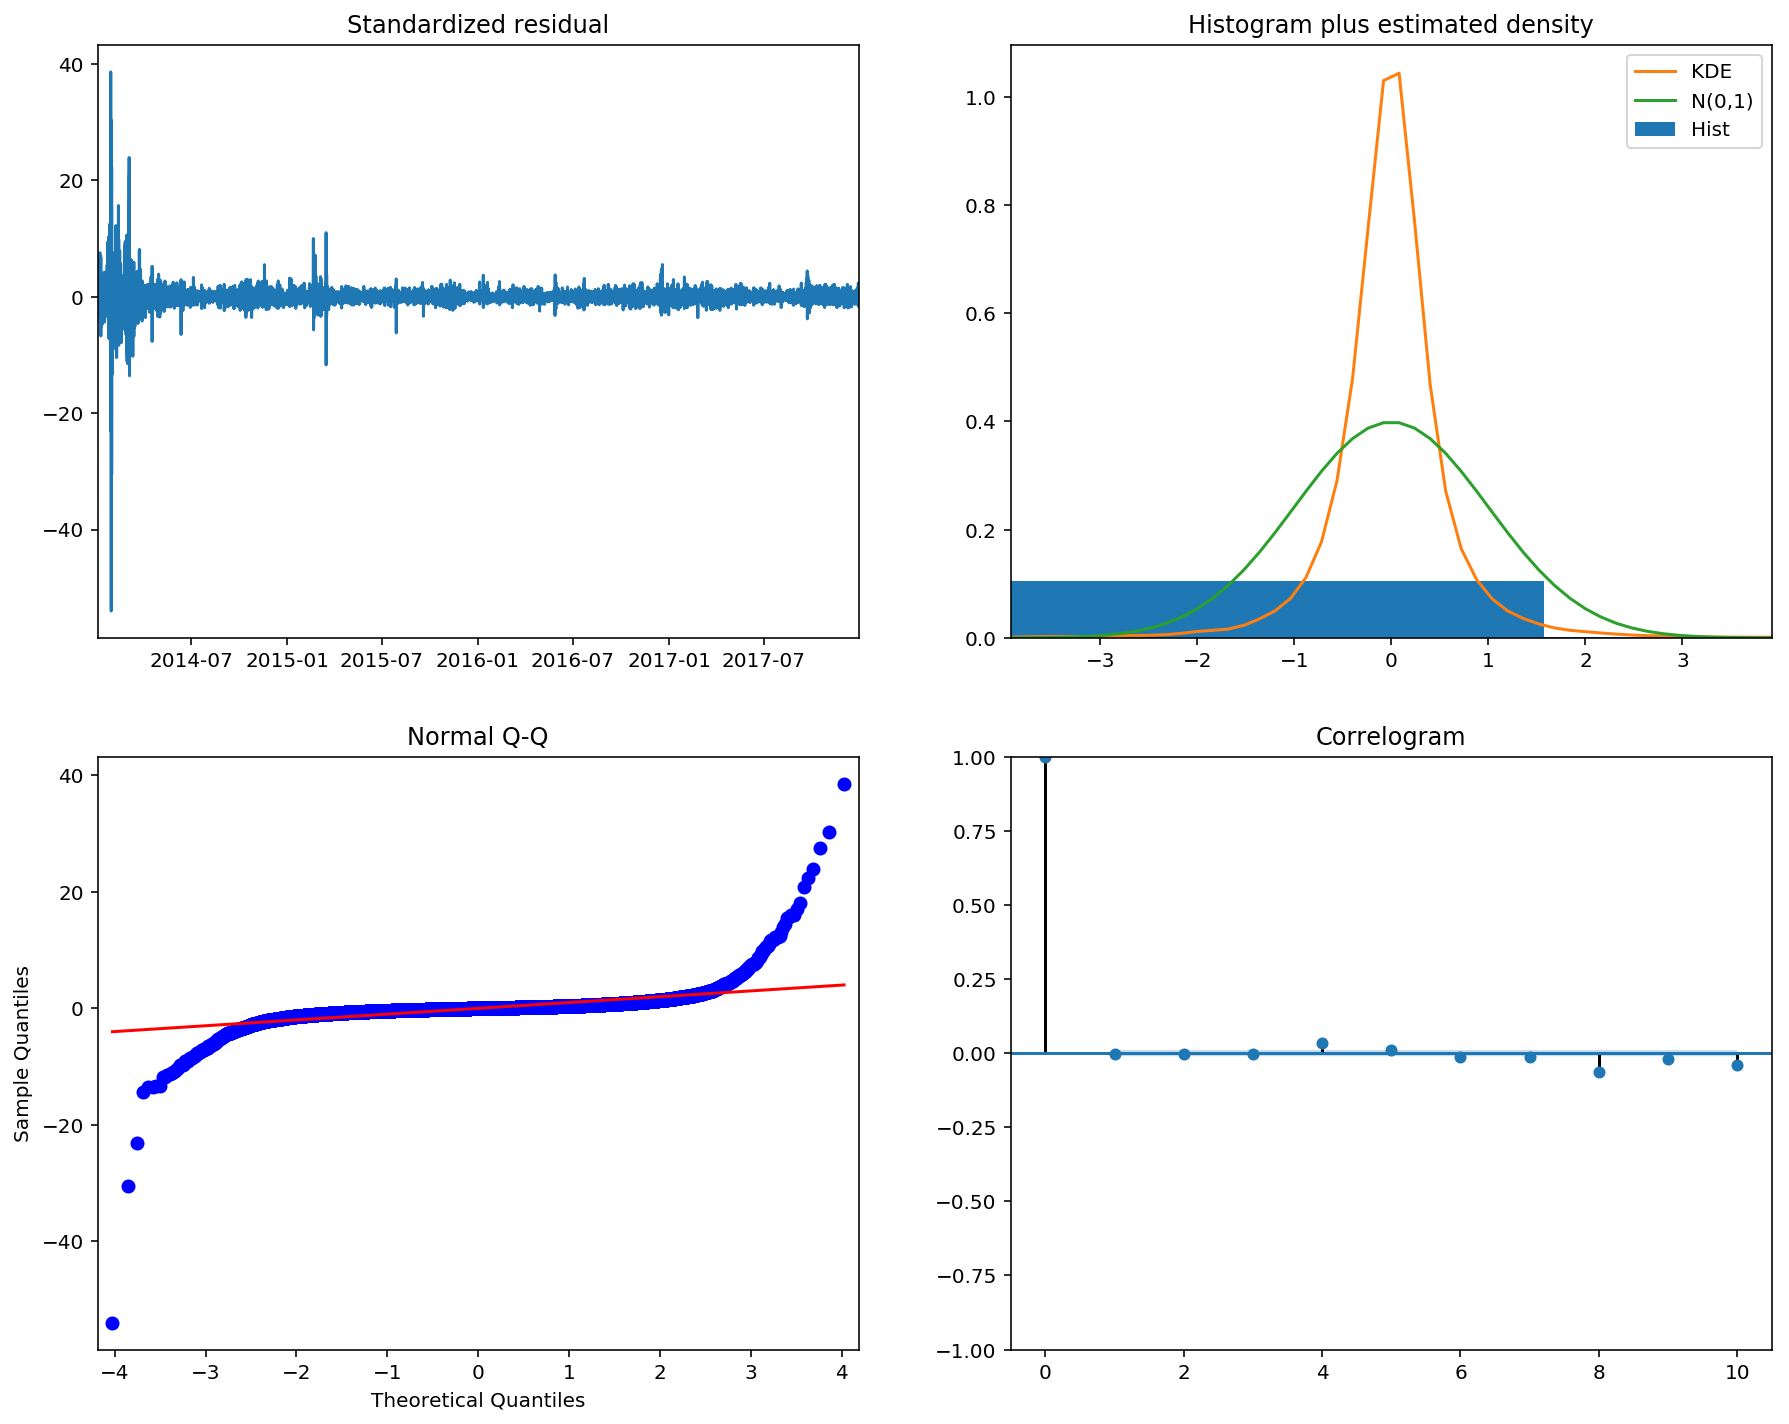

In [149]:
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

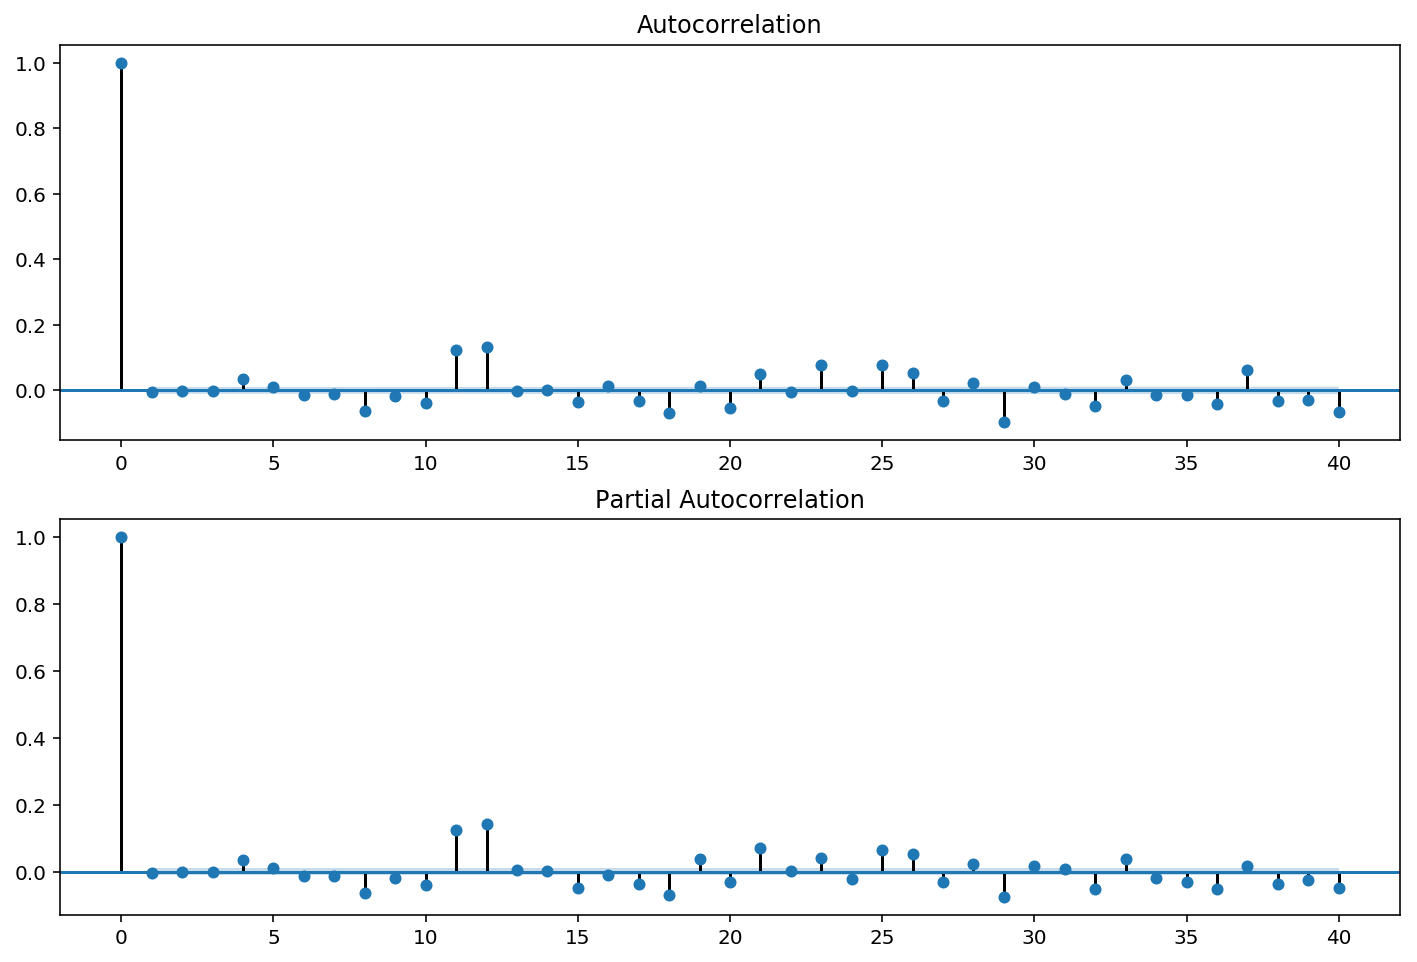

In [151]:
# Autocorrelation plots of the residuals. As with the rest of the model, it's
# not bad, but it has plenty of room for improvement.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid, lags=40, ax=ax2)
plt.show()

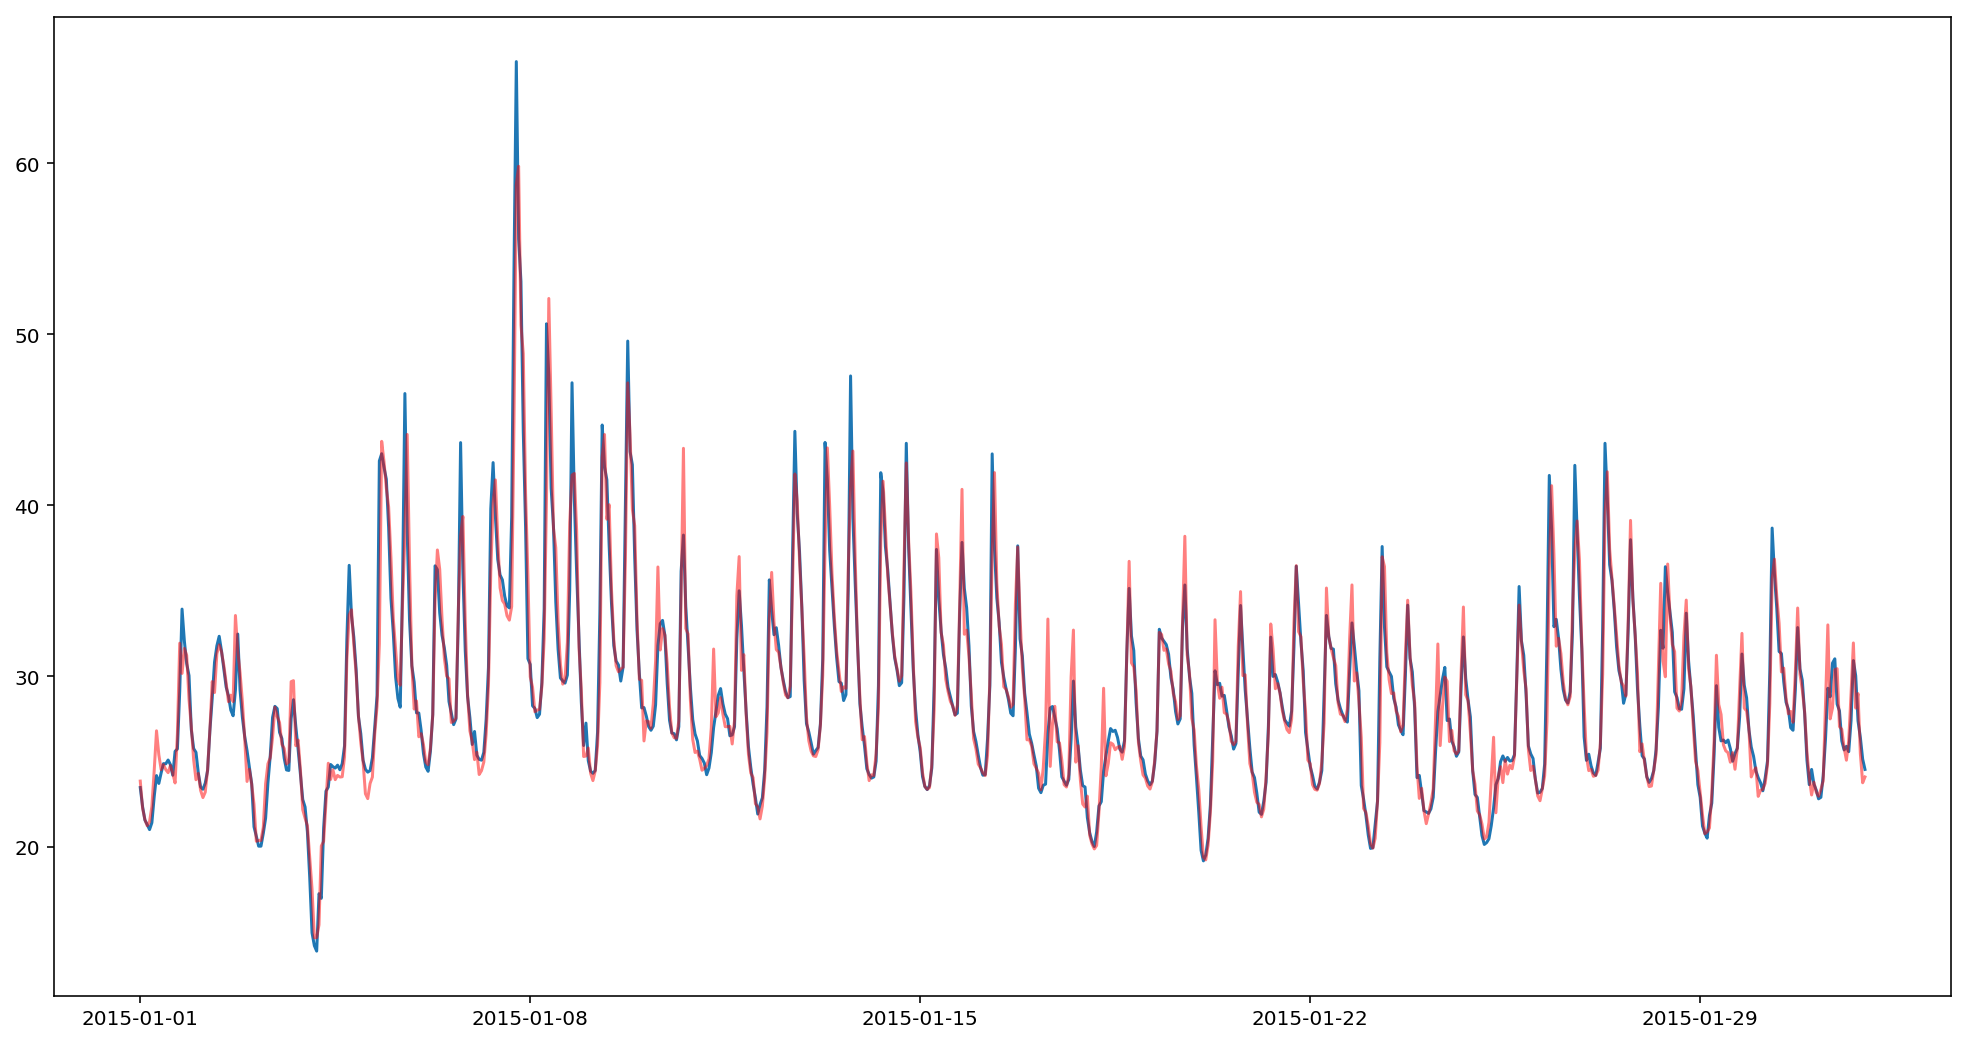

In [157]:
# In sample prediction in red. The fit is decent, but the real test is out of sample
plt.plot(df['2015-01']['DA_LMP'])
plt.plot(results.fittedvalues['2015-01'], color='red', alpha=.5);

In [161]:
# R2 score for fit of in sample predictoins
r2_score(df['DA_LMP'].values, results.fittedvalues)

0.9525137277691605

In [175]:
test = sm.tsa.statespace.SARIMAX(df[:'2017-12-21']['DA_LMP'],
                                            order=(4,0,4),
                                            seasonal_order=(1,1,1,24),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False).fit()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


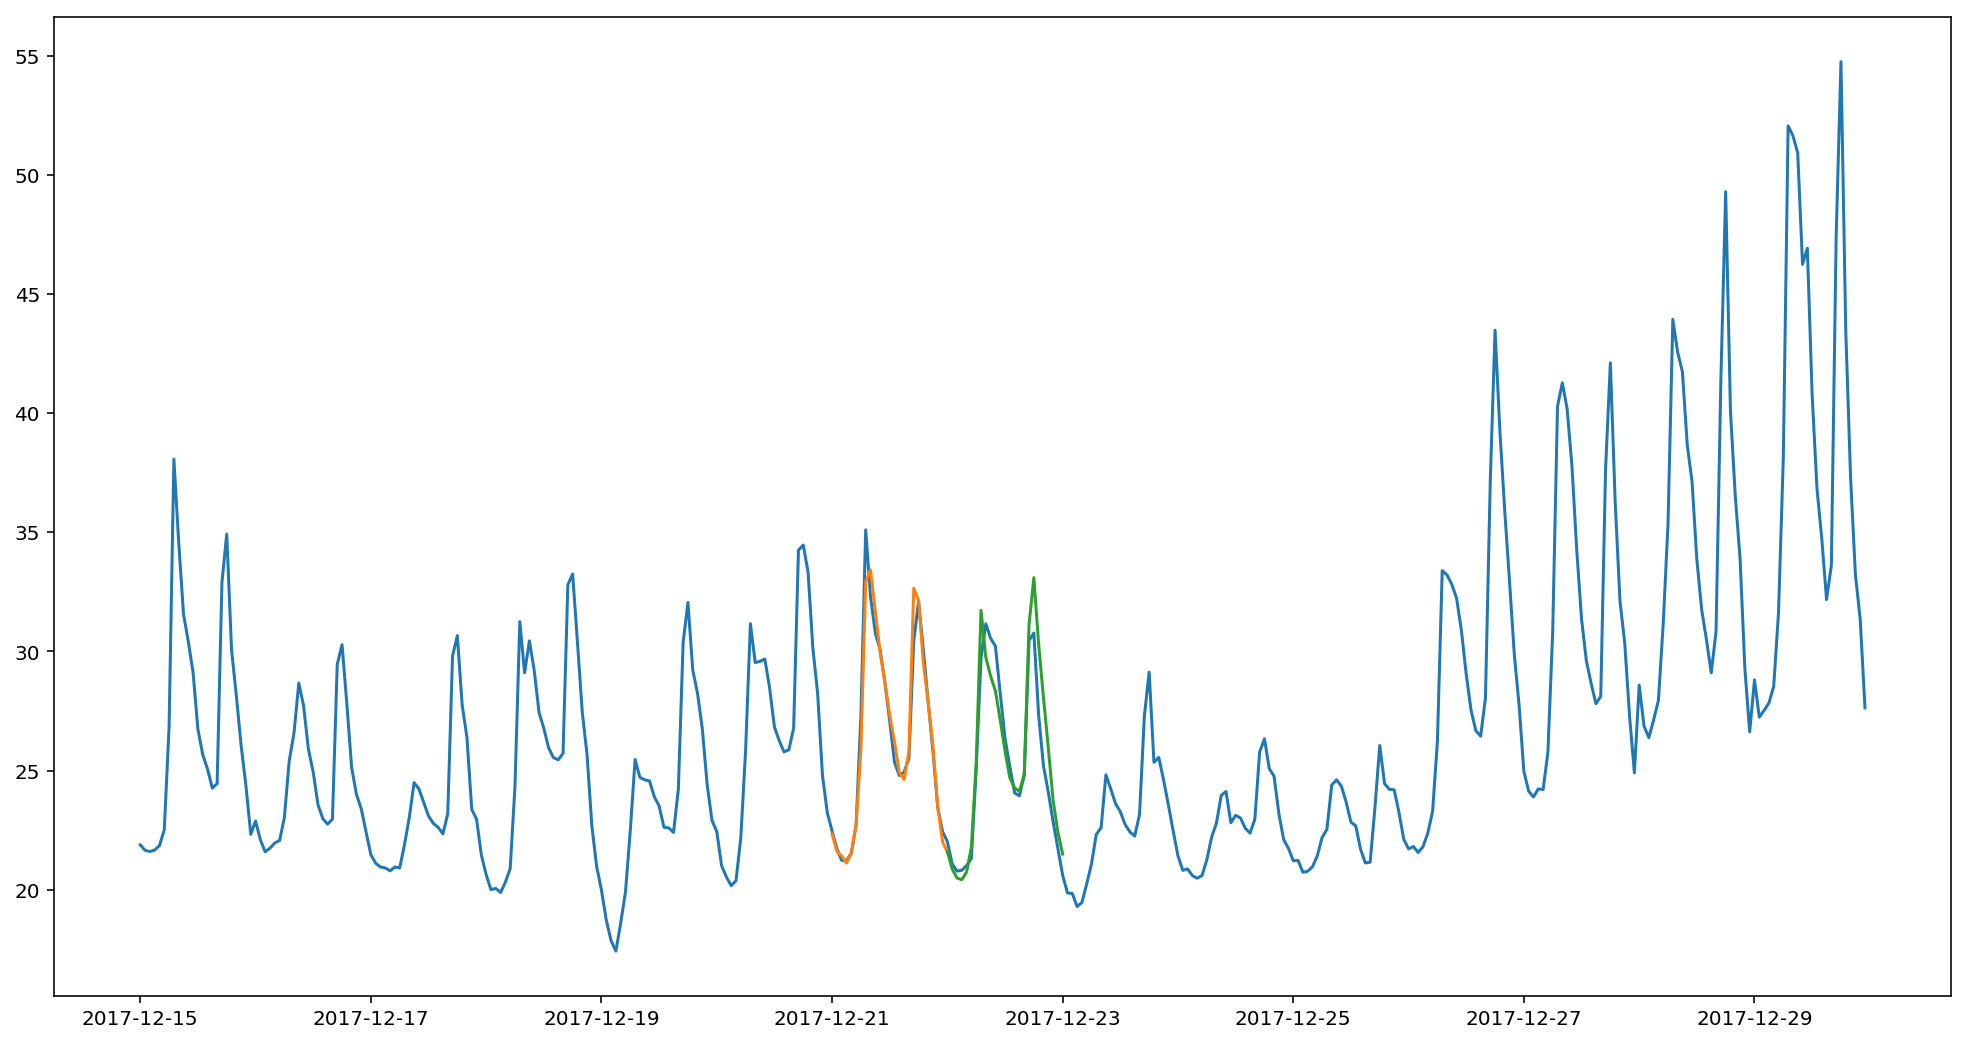

In [179]:
# A small comparison of in-sample (orange) and out-of-sample (green) prediction
# fit side by side, over top the actual values. The out of sample R2 score
# was 0.860 for 24 predicted lags and .940 for 11 predicted lags. The caveat
# is that the fit is only that good when conditions are normal.
plt.plot(df['2017-12-15':]['DA_LMP'])
plt.plot(insample_pred)
plt.plot(oosample_pred);

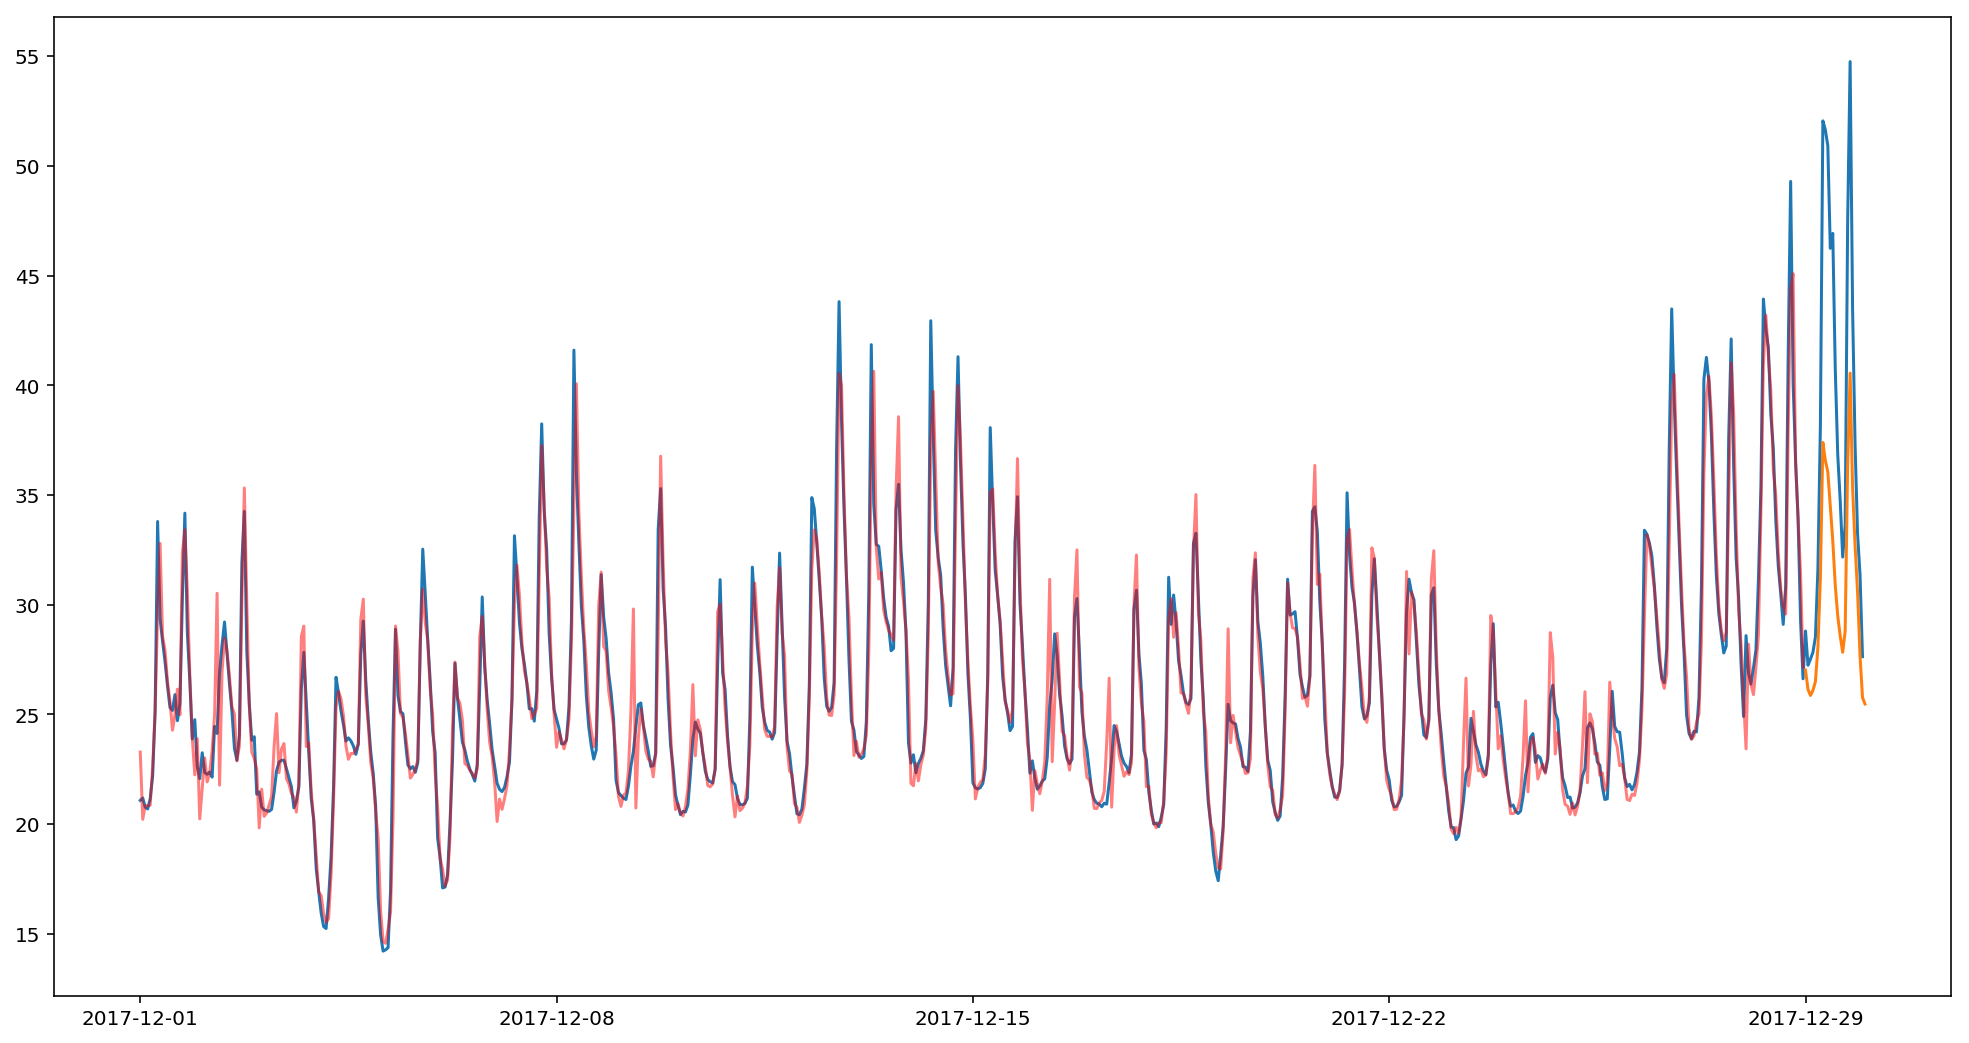

In [171]:
# During a holiday, for example, the model does not perform nearly as well.
# This can be addressed through the introduction of exogenous variables such
# as encoded holidays and other such events. In general, the only direction for
# the models to go is up.
plt.plot(df['2017-12']['DA_LMP'])
plt.plot(test.fittedvalues['2017-12'], color='red', alpha=.5);
plt.plot(preds);